In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re, string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
#import emoji
import nltk

from sklearn import preprocessing
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import demoji

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


DATA representation

In [2]:
tweet_df=pd.read_csv('trump_hashtag_lang.csv')
#,lineterminator='\n'
tweet_df
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


# DATA PREPROCESSING
Data Cleaning

In [3]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')#remove emoji

In [4]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [5]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\\w-]+(?=(?:\\s+#[\\w-]+)*\\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [6]:
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\\s\\s+" , " ", text)

In [7]:
#Removing emoji from each tweets
tweet_df['emoji']=tweet_df['tweet'].map(strip_emoji)
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [8]:
#Removing punctuations, links, mentions and \r\n new line characters from each tweet
tweet_df['entity']=tweet_df['emoji'].map(strip_all_entities)
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [9]:
#Removing hashtag from each tag
tweet_df['hashtags']=tweet_df['entity'].map(clean_hashtags)
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [10]:
#Filtering special character from each tweet
tweet_df['filter_char']=tweet_df['hashtags'].map(filter_chars)
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [11]:
#REmoving multiple space
tweet_df['mul_spa']=tweet_df['filter_char'].map(remove_mult_spaces)
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [12]:
#Filtering tweets which are in english language
english_df = tweet_df[tweet_df['language'] == 'en']

english_df

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:36.5,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4996,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:36.8,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4997,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:37.2,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4998,15-10-2020 08:13,1.320000e+18,#JudgeBarrett should withdraw her name from co...,NaN,0,0,Twitter for iPad,1.916609e+07,Kent R. Pipes,kentrpipes,...,North America,New Jersey,NJ,37:38.0,en,#JudgeBarrett should withdraw her name from co...,judgebarrett should withdraw h

In [13]:
eng_df_filtered = english_df.iloc[0:5000]
  # Randomly sample 5,000 records
eng_df_filtered

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:36.5,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4996,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:36.8,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4997,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,North America,New York,NY,37:37.2,en,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...
4998,15-10-2020 08:13,1.320000e+18,#JudgeBarrett should withdraw her name from co...,NaN,0,0,Twitter for iPad,1.916609e+07,Kent R. Pipes,kentrpipes,...,North America,New Jersey,NJ,37:38.0,en,#JudgeBarrett should withdraw her name from co...,judgebarrett should withdraw h

# BERTopic
Topic Modelling

In [14]:
from bertopic import BERTopic
#All the tweets are considered as a list 
eng_text_data = eng_df_filtered['mul_spa'].tolist() 
#Using embedding model paraphrase-MiniLM-L3-v2
model_eng = BERTopic(embedding_model="paraphrase-MiniLM-L3-v2",calculate_probabilities=True,verbose=True)


c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\umap\distances.py:1086: NumbaDepr

In [15]:
# Fitting data into BERTopic model
topics_eng, probs_eng = model_eng.fit_transform(eng_text_data)

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

2023-09-07 18:28:15,508 - BERTopic - Transformed documents to Embeddings
2023-09-07 18:28:52,017 - BERTopic - Reduced dimensionality
2023-09-07 18:28:53,841 - BERTopic - Clustered reduced embeddings


In [16]:
# Getting details of all the topics generated by BERTopic
model_eng.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1835,-1_the_trump_to_and,"[the, trump, to, and, in, is, of, you, this, for]",[why hasnt president trump told us about this ...
1,0,352,0_trump_he_you_about,"[trump, he, you, about, is, hes, the, his, be,...",[so fickle is man i dont think she really care...
2,1,167,1_nbc_town_hall_townhall,"[nbc, town, hall, townhall, boycottnbc, rating...",[hey everyone let the nbc top sponsors know yo...
3,2,128,2_coronavirus_covid19_corona_iphone,"[coronavirus, covid19, corona, iphone, covid, ...","[trump never had the coronavirus, trump never ..."
4,3,82,3_donaldtrump_funfacts_facts_republicans,"[donaldtrump, funfacts, facts, republicans, pr...","[donaldtrump, donaldtrump, donaldtrump]"
...,...,...,...,...,...
90,89,11,89_accounts_supporters_black_suspends,"[accounts, supporters, black, suspends, twitte...",[breaking news pt2 fake social media accounts ...
91,90,11,90_trumpvirusdeathtoll220k_virus_trumpisnotwel...,"[trumpvirusdeathtoll220k, virus, trumpisnotwel...",[trump has trumped america what a great guy am...
92,91,11,91_masterminds_maidan_ukraines_takeover,"[masterminds, maidan, ukraines, takeover, care...",[new york post leak is probably from trump bid...
93,92,11,92_mask_eat_kicked_southwest,"[mask, eat, kicked, southwest, flight, off, bl...",[really hes sitting in the eating section but ...


In [17]:
# Finding topic for each tweet that has been assigned by BERTopic
topicsdf_eng = pd.DataFrame(topics_eng)
topicsdf_eng

,0
0,12
1,42
2,52
3,9
4,3
...,...
4979,-1
4980,-1
4981,-1
4982,20


In [18]:
#Visualizing topics using intertopic distance map
model_eng.visualize_topics()

In [19]:
model_eng.visualize_hierarchy()

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [20]:
#Visualizing top 15 topics using barchart
model_eng.visualize_barchart(top_n_topics=15)

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



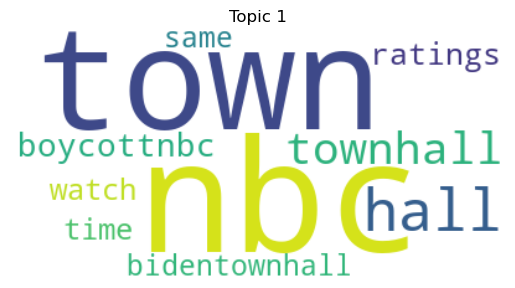

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



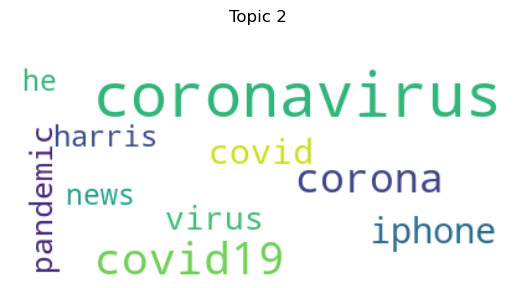

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



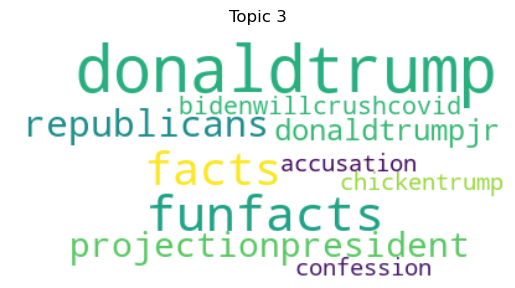

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Visualizing top 3 topics using word cloud

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic"+" "+ str(topic))
    plt.show()
 
#visualize the top 3 topics
for i in range(1,4):
    create_wordcloud(model_eng, topic=i)

Calculating Coherence Score 

In [22]:
documents = pd.DataFrame({"Document": eng_text_data,
                          "ID": range(len(eng_text_data)),
                          "Topic": topics_eng})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = model_eng._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = model_eng.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in model_eng.get_topic(topic)] 
               for topic in range(len(set(topics_eng))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence_bert = coherence_model.get_coherence()



In [23]:
coherence_bert

0.7433403787637394

In [24]:
# Generating topic labels for each topic
model_eng.generate_topic_labels()

['-1_the_trump_to',
 '0_trump_he_you',
 '1_nbc_town_hall',
 '2_coronavirus_covid19_corona',
 '3_donaldtrump_funfacts_facts',
 '4_antitrump_fucktrumpsshit_shitler',
 '5_barron_tested_positive',
 '6_deaths_covid19_fear',
 '7_twitter_facebook_censorship',
 '8_russia_russian_putin',
 '9_women_she_her',
 '10_icecube_ice_black',
 '11_rally_rallies_billboard',
 '12_china_ccp_chinas',
 '13_maga_maga2020_maga2020landslidevictory',
 '14_immunity_herd_herdimmunity',
 '15_bidenharristosaveamerica_bidenharrislandslide2020_bidenharris2020',
 '16_biden_vs_joebiden',
 '17_iowa_iowans_floods',
 '18_lose_losing_day',
 '19_black_racism_they',
 '20_amyconeybarrett_she_her',
 '21_hunterbidenemails_hunterbiden_hunter',
 '22_money_trumpforprison_kids',
 '23_tax_returns_release',
 '24_lying_liar_lies',
 '25_votethemallout_votebluedownballot_vote',
 '26_doctors_drug_obamacare',
 '27_gophypocrisy_trumpattacksblackwomen_acbhearings',
 '28_whoownstrump_trumpliesamericansdie_trumpcrimefamily',
 '29_fake_story_fake

Hyperparameter Tuning

In [25]:
import optuna

# Load your data
# Define the objective function for Optuna

def objective(trial):
    # Define the hyperparameters to be tuned
    min_topic_size = trial.suggest_int("min_topic_size", 8, 10)
    nr_topics = trial.suggest_int("nr_topics", 90,94)
    top_n_words = trial.suggest_int("top_n_words", 10, 20)
    #umap_metric = trial.suggest_categorical('umap_metric', ['cosine', 'euclidean'])

    # Create and fit the BERTopic model with the suggested hyperparameters,min_topic_size=min_topic_size,top_n_words=top_n_words
    model = BERTopic( nr_topics=nr_topics, min_topic_size=min_topic_size, top_n_words=top_n_words)
    topics_ber, _ = model.fit_transform(eng_text_data)

    # Calculate the coherence score (you can use other evaluation metrics as well)
    documents = pd.DataFrame({"Document": eng_text_data,
                          "ID": range(len(eng_text_data)),
                          "Topic": topics_ber})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = model_eng._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in model.get_topic(topic)] 
               for topic in range(len(set(topics_ber))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

    
# Create an Optuna study

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=3)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final BERTopic model with the best hyperparameters,min_topic_size=best_params["min_topic_size"],
#top_n_words=best_params["top_n_words"]
best_model = BERTopic(nr_topics=best_params["nr_topics"],min_topic_size=best_params["min_topic_size"],top_n_words=best_params["top_n_words"])

topics, _ = best_model.fit_transform(eng_text_data)

[I 2023-09-07 18:29:13,722] A new study created in memory with name: no-name-9d4e2ed3-d754-44d9-92d2-6fc16d05d7e3
2023-09-07 18:51:22,820 - BERTopic - Transformed documents to Embeddings
2023-09-07 18:51:34,440 - BERTopic - Reduced dimensionality
2023-09-07 18:51:34,688 - BERTopic - Clustered reduced embeddings
2023-09-07 18:51:35,201 - BERTopic - Reduced number of topics from 127 to 94
[I 2023-09-07 18:51:53,823] Trial 0 finished with value: 0.7179309903697941 and parameters: {'min_topic_size': 9, 'nr_topics': 94, 'top_n_words': 12}. Best is trial 0 with value: 0.7179309903697941.
2023-09-07 19:12:43,624 - BERTopic - Transformed documents to Embeddings
2023-09-07 19:12:53,985 - BERTopic - Reduced dimensionality
2023-09-07 19:12:54,199 - BERTopic - Clustered reduced embeddings
2023-09-07 19:12:54,625 - BERTopic - Reduced number of topics from 127 to 94
[I 2023-09-07 19:13:10,344] Trial 1 finished with value: 0.7355990111194517 and parameters: {'min_topic_size': 9, 'nr_topics': 94, 'top

Best Hyperparameters: {'min_topic_size': 8, 'nr_topics': 92, 'top_n_words': 11}


2023-09-07 19:54:54,529 - BERTopic - Transformed documents to Embeddings
2023-09-07 19:55:05,705 - BERTopic - Reduced dimensionality
2023-09-07 19:55:05,923 - BERTopic - Clustered reduced embeddings
2023-09-07 19:55:06,411 - BERTopic - Reduced number of topics from 143 to 92


In [26]:
documents_best = pd.DataFrame({"Document": eng_text_data,
                          "ID": range(len(eng_text_data)),
                          "Topic": topics})
documents_per_topic_best = documents_best.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs_best = best_model._preprocess_text(documents_per_topic_best.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer_best = best_model.vectorizer_model
analyzer_best = vectorizer_best.build_analyzer()

# Extract features for Topic Coherence evaluation
words_best = vectorizer_best.get_feature_names()
tokens_best = [analyzer(doc) for doc in cleaned_docs_best]
dictionary_best = corpora.Dictionary(tokens_best)
corpus_best = [dictionary_best.doc2bow(token) for token in tokens_best]
topic_words_best = [[words for words, _ in best_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model_best = CoherenceModel(topics=topic_words_best, 
                                 texts=tokens_best, 
                                 corpus=corpus_best,
                                 dictionary=dictionary_best, 
                                 coherence='c_v')
coherence_best = coherence_model_best.get_coherence()

print(f"The coherence score of the BERTopic after hyperparameter tuning for {best_params} is {coherence_best}")

The coherence score of the BERTopic after hyperparameter tuning for {'min_topic_size': 8, 'nr_topics': 92, 'top_n_words': 11} is 0.74512121564564


Calculating accuracy, F1, precision, recall

In [27]:
tweet_df=pd.read_csv('trump_acc1.csv')
#,lineterminator='\n'
tweet_df
tweet_df.head()

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020


In [28]:
eng_df_filter = tweet_df.iloc[0:300]
  # Randomly sample 300,000 records
eng_df_filter

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,North America,Ohio,OH,02:11.4,en,"He just called @CoryBooker stupid, literally. ...",he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,North America,California,CA,02:12.5,en,"#TheWeek: ""NBC cut ties with #Trump in June 20...",theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 o...
297,15-10-2020 00:19,1.320000e+18,#GOP Massachusetts #governor says he will NOT ...,trump,2,0,Twitter for iPhone,1.010000e+18,Inconvenient Truth 🌊🌊🌊,InconvenientTr5,...,NaN,NaN,NaN,02:12.1,en,#GOP Massachusetts #governor says he will NOT ...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...
298,15-10-2020 00:19,1.320000e+18,@chipfranklin They need to do it to #tRump as ...,trump,0,0,Twitter for iPhone,7.770000e+17,Artjr,artkitchen76,...,North America,California,CA,02:11.7,en,@chipfranklin They need to do it to #tRump as ...,

In [126]:
#Converting tweets into list of text
eng_text_data_trai = eng_df_filter['mul_spa'].tolist() 
#initializing an instance of the BERTopic model
model_conf = BERTopic(embedding_model="paraphrase-MiniLM-L3-v2",calculate_probabilities=True,verbose=True,min_topic_size=5,top_n_words=4)

In [161]:
topics_conf, probs_conf = model_conf.fit_transform(eng_text_data_trai)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-09-07 20:42:55,121 - BERTopic - Transformed documents to Embeddings
2023-09-07 20:42:57,137 - BERTopic - Reduced dimensionality
2023-09-07 20:42:57,177 - BERTopic - Clustered reduced embeddings


In [162]:
#Finding each topics representative words
data_df_bert=model_conf.get_topic_info()
data_df_bert

,Topic,Count,Name,Representation,Representative_Docs
0,-1,96,-1_the_trump_in_of,"[the, trump, in, of]",[what a load of rubbish black communities have...
1,0,43,0_trump_the_and_you,"[trump, the, and, you]",[trump they always ask me such hard questions ...
2,1,42,1_biden_trump_election2020_trump2020,"[biden, trump, election2020, trump2020]",[trump maga vote election usa freedom kag kag2...
3,2,18,2_donaldtrump_is_out_the,"[donaldtrump, is, out, the]",[donaldtrump is notfit to be potus because he ...
4,3,17,3_corruption_trump_no_let,"[corruption, trump, no, let]",[bc its garbage rudycolludy amp co cooked up d...
5,4,15,4_fear_deaths_so_when,"[fear, deaths, so, when]",[216000 deaths those people when away magicall...
6,5,13,5_twitter_censorship_this_hunter,"[twitter, censorship, this, hunter]",[this is serious interference and censorship i...
7,6,11,6_america_dump_trumptaxes_reckless,"[america, dump, trumptaxes, reckless]",[boycottnbctownhall dont give trump the number...
8,7,9,7_herdimmunity_trumpliesamericansdie_to_covid19,"[herdimmunity, trumpliesamericansdie, to, covi...",[trump trumpliesamericansdie 80 researchers wa...
9,8,9,8_like_he_foxnews_to,"[like, he, foxnews, to]",[am i the only one who see something seriously...


In [163]:
#Displaying output of BERT
topics_conf

[-1,
 0,
 -1,
 10,
 2,
 11,
 7,
 1,
 -1,
 5,
 1,
 3,
 1,
 0,
 3,
 1,
 -1,
 10,
 4,
 0,
 1,
 7,
 5,
 3,
 1,
 10,
 2,
 -1,
 -1,
 -1,
 6,
 6,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 2,
 0,
 7,
 0,
 0,
 4,
 4,
 1,
 1,
 -1,
 4,
 2,
 -1,
 -1,
 2,
 5,
 6,
 0,
 2,
 3,
 -1,
 -1,
 3,
 5,
 -1,
 1,
 10,
 4,
 1,
 -1,
 4,
 5,
 -1,
 12,
 -1,
 1,
 5,
 7,
 -1,
 -1,
 0,
 1,
 3,
 9,
 2,
 8,
 6,
 7,
 8,
 1,
 -1,
 4,
 0,
 1,
 11,
 1,
 -1,
 3,
 0,
 0,
 7,
 -1,
 -1,
 11,
 5,
 -1,
 2,
 -1,
 11,
 7,
 11,
 4,
 0,
 0,
 7,
 0,
 1,
 1,
 0,
 -1,
 -1,
 0,
 -1,
 1,
 0,
 0,
 5,
 0,
 4,
 -1,
 3,
 1,
 -1,
 0,
 -1,
 3,
 -1,
 9,
 -1,
 -1,
 0,
 4,
 6,
 0,
 -1,
 1,
 2,
 -1,
 3,
 12,
 0,
 -1,
 5,
 4,
 12,
 -1,
 0,
 -1,
 4,
 0,
 3,
 1,
 2,
 1,
 0,
 -1,
 1,
 -1,
 -1,
 -1,
 0,
 1,
 -1,
 -1,
 0,
 -1,
 1,
 1,
 -1,
 3,
 2,
 0,
 3,
 -1,
 -1,
 0,
 2,
 9,
 2,
 -1,
 2,
 -1,
 3,
 6,
 -1,
 -1,
 -1,
 -1,
 -1,
 0,
 -1,
 9,
 -1,
 0,
 -1,
 8,
 -1,
 1,
 11,
 8,
 -1,
 4,
 5,
 6,
 1,
 -1,
 0,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 3,
 -1,
 1,
 6,
 8,
 

In [164]:
#Sorting the topics based on the count of documents assigned the topics
topic_keywords = model_conf.get_topic_freq().sort_values("Count", ascending=False)
topic_keywords

,Topic,Count
0,-1,96
1,0,43
6,1,42
3,2,18
8,3,17
9,4,15
7,5,13
10,6,11
5,7,9
13,8,9


In [165]:
topicsdf_conf = pd.DataFrame(topics_conf)
topicsdf_conf[0]

0      -1
1       0
2      -1
3      10
4       2
       ..
295     2
296    -1
297     6
298     0
299    10
Name: 0, Length: 300, dtype: int64

In [166]:
#Finding propabilities and representative words and their probabilities
topics_info_conf = model_conf.get_topics()
topics_info_conf

{-1: [('the', 0.0483419679400642),
  ('trump', 0.03583377869626365),
  ('in', 0.030209538986249902),
  ('of', 0.029049181426583595)],
 0: [('trump', 0.057959262447714384),
  ('the', 0.044540719178965134),
  ('and', 0.04367244895602969),
  ('you', 0.0404859462653332)],
 1: [('biden', 0.04751868127035069),
  ('trump', 0.04409241661527953),
  ('election2020', 0.04191506413347682),
  ('trump2020', 0.03971674224870882)],
 2: [('donaldtrump', 0.1255650088989746),
  ('is', 0.05325399195285025),
  ('out', 0.051549309819579635),
  ('the', 0.048879100917176024)],
 3: [('corruption', 0.07381033918213624),
  ('trump', 0.059848784512382305),
  ('no', 0.05241094093471958),
  ('let', 0.05096076802908891)],
 4: [('fear', 0.07355155760140382),
  ('deaths', 0.06960073054076844),
  ('so', 0.06670088672068072),
  ('when', 0.05232611356403316)],
 5: [('twitter', 0.11182098672822195),
  ('censorship', 0.10310690490729045),
  ('this', 0.06587501147892943),
  ('hunter', 0.06444181556705653)],
 6: [('america',

In [167]:
topi_conf=[]
for topic_id_conf, topic_conf in topics_info_conf.items():
    #print(topic)  # Print to see what 'topic' contains
    topi_conf.append(topic_conf)
topi_conf

[[('the', 0.0483419679400642),
  ('trump', 0.03583377869626365),
  ('in', 0.030209538986249902),
  ('of', 0.029049181426583595)],
 [('trump', 0.057959262447714384),
  ('the', 0.044540719178965134),
  ('and', 0.04367244895602969),
  ('you', 0.0404859462653332)],
 [('biden', 0.04751868127035069),
  ('trump', 0.04409241661527953),
  ('election2020', 0.04191506413347682),
  ('trump2020', 0.03971674224870882)],
 [('donaldtrump', 0.1255650088989746),
  ('is', 0.05325399195285025),
  ('out', 0.051549309819579635),
  ('the', 0.048879100917176024)],
 [('corruption', 0.07381033918213624),
  ('trump', 0.059848784512382305),
  ('no', 0.05241094093471958),
  ('let', 0.05096076802908891)],
 [('fear', 0.07355155760140382),
  ('deaths', 0.06960073054076844),
  ('so', 0.06670088672068072),
  ('when', 0.05232611356403316)],
 [('twitter', 0.11182098672822195),
  ('censorship', 0.10310690490729045),
  ('this', 0.06587501147892943),
  ('hunter', 0.06444181556705653)],
 [('america', 0.1086557100929829),
  (

In [168]:
#Representing probability of each word in the topic
df_prob_conf=pd.DataFrame(topi_conf)
df_prob_conf

,0,1,2,3
0,"(the, 0.0483419679400642)","(trump, 0.03583377869626365)","(in, 0.030209538986249902)","(of, 0.029049181426583595)"
1,"(trump, 0.057959262447714384)","(the, 0.044540719178965134)","(and, 0.04367244895602969)","(you, 0.0404859462653332)"
2,"(biden, 0.04751868127035069)","(trump, 0.04409241661527953)","(election2020, 0.04191506413347682)","(trump2020, 0.03971674224870882)"
3,"(donaldtrump, 0.1255650088989746)","(is, 0.05325399195285025)","(out, 0.051549309819579635)","(the, 0.048879100917176024)"
4,"(corruption, 0.07381033918213624)","(trump, 0.059848784512382305)","(no, 0.05241094093471958)","(let, 0.05096076802908891)"
5,"(fear, 0.07355155760140382)","(deaths, 0.06960073054076844)","(so, 0.06670088672068072)","(when, 0.05232611356403316)"
6,"(twitter, 0.11182098672822195)","(censorship, 0.10310690490729045)","(this, 0.06587501147892943)","(hunter, 0.06444181556705653)"
7,"(america, 0.1086557100929829)","(dump, 0.08706756201233212)","(trumptaxes, 0.08706756201233212)","(reckless, 0.08706756201233212)"
8,"(herdimmunity, 0.10915670682773983)","(trumpliesamericansdie, 0.09233708097499652)","(to, 0.06573471505240408)","(covid19, 0.06394177703831871)"
9,"(like, 0.06287875138792207)","(he, 0.06249929054423696)","(foxnews, 0.062346907633418755)","(to, 0.061912929293543376)"


In [169]:
#Combining the output topic predicted by BERTopic with the input dataframe
label_df_conf=eng_df_filter.join(topicsdf_conf)
label_df_conf["label"]

0            trump
1            trump
2             iowa
3              her
4      donaldtrump
          ...     
295    donaldtrump
296          trump
297          trump
298          trump
299          trump
Name: label, Length: 300, dtype: object

In [170]:
new_column_names = {
    0:'predicted_label'
}
label_df_conf.rename(columns=new_column_names, inplace=True)

# Print the DataFrame with updated column names
label_df_conf

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa,label_encoded,predicted_label
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,-1
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,0
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,-1
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,10
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,OH,02:11.4,en,"He just called @CoryBooker stupid, literally. ...",he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,7,2
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,CA,02:12.5,en,"#TheWeek: ""NBC cut ties with #Trump in June 20...",theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 o...,20,-1
297,15-10-2020 00:19,1.320000e+18,#GOP Massachusetts #governor says he will NOT ...,trump,2,0,Twitter for iPhone,1.010000e+18,Inconvenient Truth 🌊🌊🌊,InconvenientTr5,...,NaN,02:12.1,en,#GOP Massachusetts #governor says he will NOT ...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,20,6
298,15-10-2020 00:19,1.320000e+18,@chipfranklin They need to do it to #tRump as ...,trump,0,0,Twitter for iPhone,7.770000e+17,Artjr,artkitchen76,...,CA,02:11.7,en,@chipfranklin They need to do it to #tRump as ...,they need to do it to trump as well,they need to do it to trump as well,they need to do it to trump as well,they need 

In [171]:
#Map each output to its representative words
def map_topic(label):
    topic_words_trai=model_conf.get_topic(label)
    words_only = [item_bert[0] for item_bert in topic_words_trai]
    return words_only


In [172]:
label_df_conf["predicted_topic"]=label_df_conf["predicted_label"].map(map_topic)
label_df_conf

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa,label_encoded,predicted_label,predicted_topic
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,-1,"[the, trump, in, of]"
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,0,"[trump, the, and, you]"
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,-1,"[the, trump, in, of]"
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,10,"[her, time, for, with]"
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,2,"[donaldtrump, is, out, the]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,02:11.4,en,"He just called @CoryBooker stupid, literally. ...",he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,7,2,"[donaldtrump, is, out, the]"
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,02:12.5,en,"#TheWeek: ""NBC cut ties with #Trump in June 20...",theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 o...,20,-1,"[the, trump, in, of]"
297,15-10-2020 00:19,1.320000e+18,#GOP Massachusetts #governor says he will NOT ...,trump,2,0,Twitter for iPhone,1.010000e+18,Inconvenient Truth 🌊🌊🌊,InconvenientTr5,...,02:12.1,en,#GOP Massachusetts #governor says he will NOT ...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,20,6,"[america, dump, trumptaxes, reckless]"
298,15-10-2020 00:19,1.320000e+18,@chipfranklin They need to do it to #tRump as ...,trump,0,0,Twitter for iPhone,7.770000e+17,Artjr,ar

In [173]:
#Assigning the predicted label to each tweet
def check_value_in_list(value, target_list):
    if value in target_list:
        word = value
    else:
        word = target_list[0]
    return word


In [174]:
label_df_conf['predict'] = label_df_conf.apply(lambda row: check_value_in_list(row['label'], row['predicted_topic']), axis=1)
label_df_conf

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,language,emoji,entity,hashtags,filter_char,mul_spa,label_encoded,predicted_label,predicted_topic,predict
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,-1,"[the, trump, in, of]",trump
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,0,"[trump, the, and, you]",trump
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,-1,"[the, trump, in, of]",the
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,10,"[her, time, for, with]",her
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,2,"[donaldtrump, is, out, the]",donaldtrump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,en,"He just called @CoryBooker stupid, literally. ...",he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,7,2,"[donaldtrump, is, out, the]",donaldtrump
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,en,"#TheWeek: ""NBC cut ties with #Trump in June 20...",theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 o...,20,-1,"[the, trump, in, of]",trump
297,15-10-2020 00:19,1.320000e+18,#GOP Massachusetts #governor says he will NOT ...,trump,2,0,Twitter for iPhone,1.010000e+18,Inconvenient Truth 🌊🌊🌊,InconvenientTr5,...,en,#GOP Massachusetts #governor says he will NOT ...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,gop massachusetts governor says he will not su...,20,6,"[america, dump, trumptaxes, reckless]",america
298,15-10-2020 00:19,1.320000e+18,@chipfranklin They need to do it to #tRump as ...,trump,0,0,Twitter for iPhone,7.770000e+17,Artjr,artkitchen76,

In [175]:
bert_conf_df=label_df_conf.iloc[0:100]
bert_conf_df

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,language,emoji,entity,hashtags,filter_char,mul_spa,label_encoded,predicted_label,predicted_topic,predict
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,-1,"[the, trump, in, of]",trump
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,0,"[trump, the, and, you]",trump
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,-1,"[the, trump, in, of]",the
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,10,"[her, time, for, with]",her
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,2,"[donaldtrump, is, out, the]",donaldtrump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15-10-2020 00:05,1.320000e+18,@icecube You don’t trust ‘none of them’ (Presi...,trump,0,0,Twitter for iPhone,3.047179e+09,The Doctah,DrMovieManiac,...,en,@icecube You don’t trust ‘none of them’ (Presi...,you dont trust none of them presidential cand...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,20,11,"[they, of, you, them]",they
96,15-10-2020 00:05,1.320000e+18,@maddow #AmyConeyBarrett can remember case aft...,trump,0,0,Twitter for Android,1.200000e+18,Ex- Republican,DemocratNel,...,en,@maddow #AmyConeyBarrett can remember case aft...,amyconeybarrett can remember case after case ...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,20,1,"[biden, trump, election2020, trump2020]",trump
97,15-10-2020 00:05,1.320000e+18,@donwinslow #trump is the #monster #TrumpIsNot...,trump,0,0,Twitter for iPhone,1.180000e+18,Dee Smiff,smiff_dee,...,en,@donwinslow #trump is the #monster #TrumpIsNot...,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,20,-1,"[the, trump, in, of]",trump
98,15-10-2020 00:05,1.320000e+18,@hughriminton All off #Trump merchandise is ma...,trump,0,0,Twitter for Android,9.510000e+17,Jeffrey Kennedy,kennoJT,...,en,@hughriminton All off #Trump merchandise is ma...,all off trump merc

In [176]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
bert_label=bert_conf_df["label"].tolist()
predict_bert=bert_conf_df["predict"].tolist()

# Calculate accuracy
accuracy_bert = accuracy_score(bert_label, predict_bert)

# Calculate precision
precision_bert = precision_score(bert_label, predict_bert, average='weighted')

# Calculate recall (which is the same as sensitivity)
recall_bert = recall_score(bert_label, predict_bert, average='weighted')

# Calculate F1-score
f1_bert = f1_score(bert_label, predict_bert, average='weighted')

# Print the calculated metrics
print(f"Accuracy of BERTopic: {accuracy_bert:}")
print(f"Precision of BERTopic: {precision_bert:}")
print(f"Recall of BERTopic: {recall_bert:}")
print(f"F1-score of BERTopic: {f1_bert:}")


Accuracy of BERTopic: 0.81
Precision of BERTopic: 0.9557142857142857
Recall of BERTopic: 0.81
F1-score of BERTopic: 0.8639845288326299


In [177]:
from sklearn.metrics import classification_report
print(classification_report(bert_label, predict_bert))

                           precision    recall  f1-score   support

                  america       0.00      0.00      0.00         0
                    biden       1.00      1.00      1.00         4
                    black       0.00      0.00      0.00         1
               corruption       1.00      0.80      0.89         5
                  covid19       1.00      0.33      0.50         3
              donaldtrump       1.00      1.00      1.00         7
             election2020       1.00      0.88      0.93         8
                     fear       0.71      1.00      0.83         5
                      her       0.50      1.00      0.67         2
             herdimmunity       1.00      1.00      1.00         5
                     iowa       0.00      0.00      0.00         1
                     like       0.00      0.00      0.00         0
                      the       0.00      0.00      0.00         0
                     they       0.00      0.00      0.00     

<Figure size 800x600 with 0 Axes>

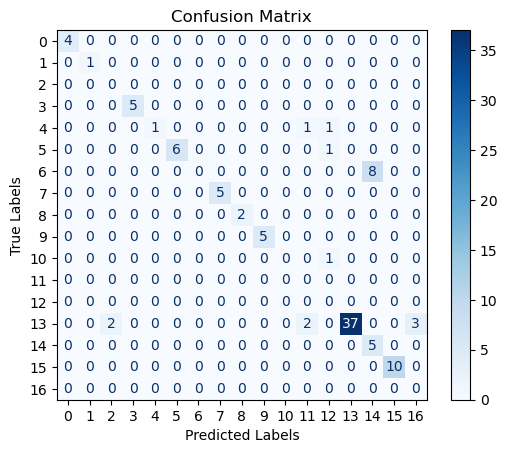

In [47]:
cm = confusion_matrix(bert_label, predict_bert)

# Create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Cosine Similarity

In [48]:
extracted_words_bert = []

# Loop through each list of tuples
for tuple_list_bert in topi_conf:
    # Extract words from each tuple and add them to the list
    words_bert = [word for word, _ in tuple_list_bert]
    extracted_words_bert.append(words_bert)

# Print the extracted words for each list
extracted_words_bert

[['the', 'trump', 'of', 'in'],
 ['trump2020', 'trump', 'biden', 'the'],
 ['twitter', 'censorship', 'trump', 'you'],
 ['corruption', 'trump', 'gop', 'russia'],
 ['so', 'fear', 'deaths', 'to'],
 ['donaldtrump', 'is', 'know', 'the'],
 ['america', 'trump', 'the', 'trumptaxes'],
 ['you', 'your', 'ask', 'one'],
 ['herdimmunity', 'trumpliesamericansdie', 'covid19', 'to'],
 ['busy', 'worry', 'and', 'the'],
 ['black', 'her', 'for', 'with'],
 ['trump', 'outset', 'played', 'sane'],
 ['covid19', 'his', 'consequences', 'enablers']]

In [49]:
labels_ber= eng_df_filter["label"].tolist()
labels_ber

['trump',
 'trump',
 'iowa',
 'her',
 'donaldtrump',
 'trump',
 'herdimmunity',
 'election2020',
 'trump',
 'twitter',
 'trump2020',
 'corruption',
 'biden',
 'trump',
 'corruption',
 'election2020',
 'trump',
 'trump',
 'covid19',
 'trump',
 'trump2020',
 'herdimmunity',
 'twitter',
 'trump',
 'biden',
 'her',
 'donaldtrump',
 'trump',
 'trump',
 'trump',
 'trump',
 'trump',
 'trump',
 'trump',
 'black',
 'trump',
 'trump',
 'trump',
 'biden',
 'biden',
 'election2020',
 'donaldtrump',
 'trump',
 'herdimmunity',
 'trump',
 'trump',
 'fear',
 'fear',
 'trump',
 'election2020',
 'trump',
 'fear',
 'donaldtrump',
 'covid19',
 'trump',
 'donaldtrump',
 'twitter',
 'trump',
 'trump',
 'donaldtrump',
 'corruption',
 'trump',
 'trump',
 'corruption',
 'twitter',
 'twitter',
 'election2020',
 'trump',
 'fear',
 'election2020',
 'trump',
 'fear',
 'twitter',
 'corruption',
 'covid19',
 'trump',
 'election2020',
 'twitter',
 'herdimmunity',
 'trump',
 'twitter',
 'trump',
 'trump2020',
 'trump'

In [50]:
list_of_lists_bert = [[item_be] for item_be in labels_ber]

print(list_of_lists_bert)


[['trump'], ['trump'], ['iowa'], ['her'], ['donaldtrump'], ['trump'], ['herdimmunity'], ['election2020'], ['trump'], ['twitter'], ['trump2020'], ['corruption'], ['biden'], ['trump'], ['corruption'], ['election2020'], ['trump'], ['trump'], ['covid19'], ['trump'], ['trump2020'], ['herdimmunity'], ['twitter'], ['trump'], ['biden'], ['her'], ['donaldtrump'], ['trump'], ['trump'], ['trump'], ['trump'], ['trump'], ['trump'], ['trump'], ['black'], ['trump'], ['trump'], ['trump'], ['biden'], ['biden'], ['election2020'], ['donaldtrump'], ['trump'], ['herdimmunity'], ['trump'], ['trump'], ['fear'], ['fear'], ['trump'], ['election2020'], ['trump'], ['fear'], ['donaldtrump'], ['covid19'], ['trump'], ['donaldtrump'], ['twitter'], ['trump'], ['trump'], ['donaldtrump'], ['corruption'], ['trump'], ['trump'], ['corruption'], ['twitter'], ['twitter'], ['election2020'], ['trump'], ['fear'], ['election2020'], ['trump'], ['fear'], ['twitter'], ['corruption'], ['covid19'], ['trump'], ['election2020'], ['twi

In [51]:
flattened_list_bert_label = [item for sublist in list_of_lists_bert for item in sublist]

print(flattened_list_bert_label)

flattened_list_bert_pre = [item for sublist in extracted_words_bert for item in sublist]

print(flattened_list_bert_pre)


['trump', 'trump', 'iowa', 'her', 'donaldtrump', 'trump', 'herdimmunity', 'election2020', 'trump', 'twitter', 'trump2020', 'corruption', 'biden', 'trump', 'corruption', 'election2020', 'trump', 'trump', 'covid19', 'trump', 'trump2020', 'herdimmunity', 'twitter', 'trump', 'biden', 'her', 'donaldtrump', 'trump', 'trump', 'trump', 'trump', 'trump', 'trump', 'trump', 'black', 'trump', 'trump', 'trump', 'biden', 'biden', 'election2020', 'donaldtrump', 'trump', 'herdimmunity', 'trump', 'trump', 'fear', 'fear', 'trump', 'election2020', 'trump', 'fear', 'donaldtrump', 'covid19', 'trump', 'donaldtrump', 'twitter', 'trump', 'trump', 'donaldtrump', 'corruption', 'trump', 'trump', 'corruption', 'twitter', 'twitter', 'election2020', 'trump', 'fear', 'election2020', 'trump', 'fear', 'twitter', 'corruption', 'covid19', 'trump', 'election2020', 'twitter', 'herdimmunity', 'trump', 'twitter', 'trump', 'trump2020', 'trump', 'election2020', 'donaldtrump', 'twitter', 'trump', 'herdimmunity', 'twitter', 'tr

In [52]:
# Given a list with repeating words
#word_list = ['apple', 'banana', 'apple', 'orange', 'banana', 'grape']

# Convert the list into a set to remove duplicates
unique_word_set_bert = set(flattened_list_bert_label)

# Convert the set back into a list
unique_word_list_be = list(unique_word_set_bert)
unique_word_list_b=unique_word_list_be.pop(0)

print(len(unique_word_list_be))


25


In [53]:
# Given a list with repeating words
#word_list = ['apple', 'banana', 'apple', 'orange', 'banana', 'grape']

# Convert the list into a set to remove duplicates
unique_word_set_re_bert = set(flattened_list_bert_pre)

# Convert the set back into a list
unique_word_list_re_bert = list(unique_word_set_re_bert)

print(len(unique_word_list_re_bert))


40


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert the lists into space-separated strings
text_re_bert = ' '.join(unique_word_list_re_bert)
text_original_bert = ' '.join(unique_word_list_re_bert)

# Create a CountVectorizer instance
vectorizer_be = CountVectorizer()

# Fit and transform the data to create the bag-of-words representation
bag_of_words_matrix_re_bert = vectorizer_be.fit_transform([text_re_bert])
bag_of_words_matrix_original_bert = vectorizer_be.transform([text_original_bert])

# Calculate cosine similarity between the two bag-of-words representations
cosine_sim_bert = cosine_similarity(bag_of_words_matrix_re_bert, bag_of_words_matrix_original_bert)

print(f"Cosine Similarity for BERTopic label and predicted values: {cosine_sim_bert[0][0]}")


Cosine Similarity for BERTopic label and predicted values: 1.0000000000000004


# Top2Vec


In [55]:
nlp = spacy.load('en_core_web_lg')

In [56]:


# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')
     

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(eng_df_filtered['mul_spa'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
eng_df_filtered['tokens'] = tokens
     

In [57]:


# Make tokens a string again
eng_df_filtered['tokens_back_to_text'] = [' '.join(map(str, l)) for l in eng_df_filtered['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

eng_df_filtered['lemmas'] = eng_df_filtered['tokens_back_to_text'].apply(get_lemmas)
     

# Make lemmas a string again
eng_df_filtered['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in eng_df_filtered['lemmas']]
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\\w*\\d\\w*', '', text) # Remove words containing numbers
    #tokens = re.sub('@*!*$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
eng_df_filtered['lemma_tokens'] = eng_df_filtered['lemmas_back_to_text'].apply(tokenize)
eng_df_filtered

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,emoji,entity,hashtags,filter_char,mul_spa,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,"[trump, student, hear, years, years, heard, ch...",trump student hear years years heard china 201...,"[trump, student, hear, year, year, hear, china...",trump student hear year year hear china 2019 1...,"[trump, student, hear, year, year, hear, china..."
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,"[2, hours, tweet, trump, maybe, busy, tremendo...",2 hours tweet trump maybe busy tremendously busy,"[2, hour, tweet, trump, maybe, busy, tremendou...",2 hour tweet trump maybe busy tremendously busy,"[hour, tweet, trump, maybe, busy, tremendously..."
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,trump,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]"
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,black,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,"[15, minutes, long, time, ago, omarosa, repres...",15 minutes long time ago omarosa represented b...,"[15, minute, long, time, ago, omarosa, represe...",15 minute long time ago omarosa represent blac...,"[minute, long, time, ago, omarosa, represent, ..."
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,dick,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,15-10-2020 08:13,1.320000e+18,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,NaN,0,0,Twitter for Android,1.310000e+18,hi,MaskingKills,...,#Trump #Trump2020 #BlackLivesMatter #BlackOpsC...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,trump trump2020 blacklivesmatter blackopscoldw...,"[trump, trump2020, blacklivesmatter, blackopsc...",trump trump2020 blacklivesmatter blackopscoldw...,"[trump, trump2020, blacklivesmatter, blackopsc...",trump trump2020 blacklivesmatter blackopscoldw...,"[trump, blacklivesmatter, blackopsc

In [58]:
from top2vec import Top2Vec
modeltop2vec = Top2Vec(eng_df_filtered['mul_spa'].values)

2023-09-07 19:56:36,497 - top2vec - INFO - Pre-processing documents for training
2023-09-07 19:56:37,092 - top2vec - INFO - Creating joint document/word embedding
2023-09-07 19:56:45,406 - top2vec - INFO - Creating lower dimension embedding of documents
2023-09-07 19:56:57,566 - top2vec - INFO - Finding dense areas of documents
2023-09-07 19:56:57,710 - top2vec - INFO - Finding topics


In [59]:
modeltop2vec.get_num_topics()

1

In [60]:
modeltop2vec.topic_words

array([['bidentownhall', 'via', 'an', 'million', 'being', 'money',
        'youre', 'house', 'china', 'campaign', 'made', 'check', 'also',
        'family', 'must', 'usa', 'potus', 'new', 'back', 'obama',
        'administration', 'stop', 'because', 'watch', 'rallies',
        'censorship', 'elections', 'lying', 'spread', 'another',
        'votebidenharris', 'against', 'republican', 'where', 'joebiden',
        'still', 'media', 'man', 'voters', 'americans', 'ukraine',
        'corrupt', 'today', 'politics', 'tax', 'only', 'first', 'women',
        'news', 'big']], dtype='<U15')

In [61]:
modeltop2vec.get_topics()

(array([['bidentownhall', 'via', 'an', 'million', 'being', 'money',
         'youre', 'house', 'china', 'campaign', 'made', 'check', 'also',
         'family', 'must', 'usa', 'potus', 'new', 'back', 'obama',
         'administration', 'stop', 'because', 'watch', 'rallies',
         'censorship', 'elections', 'lying', 'spread', 'another',
         'votebidenharris', 'against', 'republican', 'where', 'joebiden',
         'still', 'media', 'man', 'voters', 'americans', 'ukraine',
         'corrupt', 'today', 'politics', 'tax', 'only', 'first', 'women',
         'news', 'big']], dtype='<U15'),
 array([[0.99220073, 0.99082375, 0.9868927 , 0.98659194, 0.9853327 ,
         0.98516715, 0.98489845, 0.9832096 , 0.9829157 , 0.9826572 ,
         0.9825126 , 0.9821855 , 0.98159826, 0.98157877, 0.98151875,
         0.9809128 , 0.98068273, 0.9801004 , 0.97933966, 0.97927773,
         0.9792307 , 0.9790372 , 0.97883946, 0.9784554 , 0.97843826,
         0.978168  , 0.97787726, 0.9777483 , 0.9772818 , 0

In [62]:
#model.generate_topic_wordcloud(0) 
#visualize the top 3 topics
num_top= modeltop2vec.get_num_topics()
if num_top<4:
    no_top=num_top
else:
    no_top=4
for i in range(1,no_top):
    modeltop2vec.generate_topic_wordcloud(i)

In [63]:
# Get the number of topics discovered by Top2Vec
num_topics = modeltop2vec.get_num_topics()

# Get the topic words for each topic
for topic_id in range(num_topics):
    topic_words, word_scores, topic_nums = modeltop2vec.get_topics(topic_id)
    print(f"Topic {topic_id}:")
    for word in topic_words:
        print(f"- {word}")
    #print()

Topic 0:


In [64]:
id2wordtop = Dictionary(eng_df_filtered['lemma_tokens'])
print(len(id2wordtop))
id2wordtop.filter_extremes(no_below=2, no_above=.99)
print(len(id2wordtop))

10704
4828


In [65]:
corpus_top = [id2wordtop.doc2bow(d) for d in eng_df_filtered['lemma_tokens']]

In [66]:
tokenizertop = lambda s: re.findall( '\\w+', s.lower() )
textstop = [ tokenizer(t) for t in  eng_df_filtered['mul_spa'] ]

In [67]:
topic_words_top2vec, word_scores_top2vec, topic_nums_top2vec = modeltop2vec.get_topics(num_topics)
topic_words_top2vec

array([['bidentownhall', 'via', 'an', 'million', 'being', 'money',
        'youre', 'house', 'china', 'campaign', 'made', 'check', 'also',
        'family', 'must', 'usa', 'potus', 'new', 'back', 'obama',
        'administration', 'stop', 'because', 'watch', 'rallies',
        'censorship', 'elections', 'lying', 'spread', 'another',
        'votebidenharris', 'against', 'republican', 'where', 'joebiden',
        'still', 'media', 'man', 'voters', 'americans', 'ukraine',
        'corrupt', 'today', 'politics', 'tax', 'only', 'first', 'women',
        'news', 'big']], dtype='<U15')

In [68]:
# Convert the NumPy array to a Python list
python_list_top = topic_words_top2vec.tolist()

# Print the Python list
print(len(python_list_top))

1


In [69]:
# Use list comprehension to create a list of the first item from each sublist
top2vec_topic = [sublist[0] for sublist in python_list_top]

# Print the list of first items
print(top2vec_topic)

['bidentownhall']


In [70]:

top2vec_topic=[]
# Print the topics
for topic_words_top2 in python_list_top:
        top2vec_topic.append(topic_words_top2)    

In [71]:
# Evaluate
coherence_model_top = CoherenceModel(topics=top2vec_topic, 
                                 texts=eng_df_filtered['lemma_tokens'], 
                                 corpus=corpus,
                                 dictionary=id2wordtop, 
                                 coherence='c_v')
coherence_top = coherence_model_top.get_coherence()
coherence_top
print(f"The coherence score of Top2Vec is {coherence_top}")

The coherence score of Top2Vec is 0.5295900982924155


In [72]:
import pandas as pd
from bertopic import BERTopic
import optuna

# Load your data

# Define the objective function for Optuna

def objective(trial):
    # Define the hyperparameters to be tuned
    min_count = trial.suggest_int("min_count", 5, 20)
    #nr_topics = trial.suggest_int("nr_topics", 90,94)
    workers = trial.suggest_int("workers", 4,8)

    # Create and fit the BERTopic model with the suggested hyperparameters
    model_t =Top2Vec(eng_df_filtered['mul_spa'].values,min_count=min_count, workers=workers)

    # Calculate the coherence score (you can use other evaluation metrics as well)
    i= model_t.get_num_topics()
    topic_words_t, word_scores_t, topic_nums_t = model_t.get_topics(i)

    python_list_t = topic_words_t.tolist()
    top2vec_topic_t = [sublist for sublist in python_list_t]

    coherence_model_t = CoherenceModel(topics=top2vec_topic_t,texts=eng_df_filtered['lemma_tokens'],
                                       corpus=corpus,dictionary=id2wordtop,coherence='c_v')

    coherence = coherence_model_t.get_coherence()

    return coherence

 

# Create an Optuna study

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=10)

 

# Get the best hyperparameters

best_params = study.best_params

print("Best Hyperparameters:", best_params)

 

# Train the final BERTopic model with the best hyperparameters

best_model_top = Top2Vec(eng_df_filtered['mul_spa'].values,min_count=best_params["min_count"],

                      workers=best_params["workers"],)

 

i= best_model_top.get_num_topics()

topic_word_besttop, word_score_besttop, topic_num_besttop = best_model_top.get_topics(i)

 

python_lists_top = topic_word_besttop.tolist()

top2vec_top = [sublist for sublist in python_lists_top]

 

coherence_mode_besttop = CoherenceModel(topics=top2vec_top,texts=eng_df_filtered['lemma_tokens'],corpus=corpus,
                                dictionary=id2wordtop,coherence='c_v')
coherence_sc_besttop = coherence_mode_besttop.get_coherence()
coherence_sc_besttop

[I 2023-09-07 19:57:07,080] A new study created in memory with name: no-name-38705a9a-ef11-43c5-91e6-34c738b48051
2023-09-07 19:57:07,086 - top2vec - INFO - Pre-processing documents for training
2023-09-07 19:57:07,274 - top2vec - INFO - Creating joint document/word embedding
2023-09-07 19:57:17,647 - top2vec - INFO - Creating lower dimension embedding of documents
2023-09-07 19:57:27,627 - top2vec - INFO - Finding dense areas of documents
2023-09-07 19:57:27,803 - top2vec - INFO - Finding topics
[I 2023-09-07 19:57:34,871] Trial 0 finished with value: 0.5620189778624225 and parameters: {'min_count': 18, 'workers': 5}. Best is trial 0 with value: 0.5620189778624225.
2023-09-07 19:57:34,871 - top2vec - INFO - Pre-processing documents for training
2023-09-07 19:57:35,082 - top2vec - INFO - Creating joint document/word embedding
2023-09-07 19:57:45,664 - top2vec - INFO - Creating lower dimension embedding of documents
2023-09-07 19:57:55,413 - top2vec - INFO - Finding dense areas of docum

Best Hyperparameters: {'min_count': 15, 'workers': 5}


2023-09-07 20:02:21,164 - top2vec - INFO - Creating lower dimension embedding of documents
2023-09-07 20:02:30,961 - top2vec - INFO - Finding dense areas of documents
2023-09-07 20:02:31,135 - top2vec - INFO - Finding topics


0.6220089584962908

In [73]:
i= best_model_top.get_num_topics()

topic_word_be_top, word_score_be_top, topic_num_be_top = best_model_top.get_topics(i)

 

python_lists = topic_word_be_top.tolist()

top2vec_top = [sublist for sublist in python_lists]

 

coherence_mode_be_top = CoherenceModel(topics=top2vec_top,texts=eng_df_filtered['lemma_tokens'],corpus=corpus,
                                dictionary=id2wordtop,coherence='c_v')
coherence_sc_be_top = coherence_mode_be_top.get_coherence()
coherence_sc_be_top
print(f"The coherence score of Top2Vec is {coherence_sc_be_top}")

The coherence score of Top2Vec is 0.6220089584962908


Latent Dirichlet Allocation

In [74]:
def create_dictionary(words):
    return corpora.Dictionary(words)
#passing the dataframe column having tokens as the argument
id2word_lda=create_dictionary(eng_df_filtered['lemma_tokens'])
print(id2word_lda)

Dictionary<10704 unique tokens: ['ask', 'china', 'hear', 'know', 'million']...>


In [75]:
corpus_lda = [id2word_lda.doc2bow(d) for d in eng_df_filtered['lemma_tokens']]
print(corpus[0])

[(0, 1), (1, 10), (2, 5), (3, 3), (4, 2), (5, 1), (6, 1), (7, 2), (8, 3), (9, 1), (10, 1), (11, 2), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 5), (18, 2), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 4), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 2), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 2), (57, 1), (58, 1), (59, 4), (60, 1), (61, 9), (62, 3), (63, 19), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 30), (74, 1), (75, 1), (76, 46), (77, 1), (78, 2), (79, 18), (80, 2), (81, 1), (82, 3), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 1), (91, 1), (92, 4), (93, 1), (94, 1), (95, 2), (96, 7), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 5), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110

In [76]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_lda,
 id2word=id2word_lda,
 num_topics=10,
 random_state=100,
 )

In [77]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(eng_df_filtered['mul_spa'])
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(eng_df_filtered['mul_spa'])

In [78]:
#import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Assuming you have a list of preprocessed documents named 'documents'
# Create a CountVectorizer and fit_transform the documents
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(eng_df_filtered['mul_spa'])


In [79]:
lda_tf = LatentDirichletAllocation(n_components=34, random_state=42)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
#lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
#lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=34, random_state=42)

In [80]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [81]:
feature_names = tf_vectorizer.get_feature_names()
num_top_words_lda = 10  # Specify the number of top words per topic

for topic_idx, topic in enumerate(lda_tf.components_):
    top_words_indices = topic.argsort()[:-num_top_words_lda - 1:-1]
    top_words_lda = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx}: {', '.join(top_words_lda)}")

Topic 0: supporters, like, support, amp, funny, today, second, term, spread, reports
Topic 1: voting, voters, trying, mind, women, like, barrett, lot, bidens, damn
Topic 2: america, think, donaldtrump, shit, president, political, like, hope, video, fuck
Topic 3: black, years, icecube, democrats, donaldtrump, republican, people, wants, just, republicans
Topic 4: twitter, biden, joebiden, facebook, donaldtrump, hunterbiden, censorship, stop, election, hunterbidenemails
Topic 5: biden, usa, joe, coronavirus, covid, hunter, amyconeybarrett, epstein, macron, beirut
Topic 6: hes, hate, need, man, really, saudi, saw, donaldtrump, ivanka, business
Topic 7: aids, americans, vaccine, amp, deaths, killed, dead, mask, came, died
Topic 8: lies, amp, corrupt, administration, yes, immunity, lying, herd, knew, liar
Topic 9: states, wake, united, economy, message, stimulus, biden, times, arent, probably
Topic 10: trumpisalaughingstock, america, campaign, trumpcrimefamily, americaortrump, trumpprojectio

In [82]:
for index,topic in enumerate(lda_tf.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['tells', 'lol', 'sounds', 'coronavirus', 'virus', 'reports', 'spread', 'term', 'second', 'today', 'funny', 'amp', 'support', 'like', 'supporters']


THE TOP 15 WORDS FOR TOPIC #1
['suburban', 'poll', 'amy', 'pennsylvania', 'objective', 'damn', 'bidens', 'lot', 'barrett', 'like', 'women', 'mind', 'trying', 'voters', 'voting']


THE TOP 15 WORDS FOR TOPIC #2
['biden', 'ive', 'great', 'seen', 'just', 'fuck', 'video', 'hope', 'like', 'political', 'president', 'shit', 'donaldtrump', 'think', 'america']


THE TOP 15 WORDS FOR TOPIC #3
['election', 'hard', 'democrat', 'vote', 'way', 'republicans', 'just', 'wants', 'people', 'republican', 'donaldtrump', 'democrats', 'icecube', 'years', 'black']


THE TOP 15 WORDS FOR TOPIC #4
['big', 'fact', 'article', 'story', 'deal', 'hunterbidenemails', 'election', 'stop', 'censorship', 'hunterbiden', 'donaldtrump', 'facebook', 'joebiden', 'biden', 'twitter']


THE TOP 15 WORDS FOR TOPIC #5
['ukraine', 'borisjohnson', 'england

LDA Multicore

In [83]:
id2word_l = Dictionary(eng_df_filtered['lemma_tokens'])
print(len(id2word_l))

10704


In [84]:
id2word_l.filter_extremes(no_below=2, no_above=.99)
print(len(id2word_l))

4828


In [85]:
corpus_l = [id2word_l.doc2bow(d) for d in eng_df_filtered['lemma_tokens']]

In [86]:
base_model = LdaMulticore(corpus=corpus_l, num_topics=94, id2word=id2word_l, workers=12, passes=5)

In [87]:
wordslda = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [88]:
topicsLDA = [', '.join(t[0:10]) for t in wordslda]


In [89]:
for topic_id_lda, topic_lda in base_model.show_topics(num_words=5, formatted=False):
    words = [word for word, _ in topic_lda]
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: trump, donaldtrump, fourmoreyear, election, trumpery
Topic 0: trump, iowa, live, des, moines
Topic 0: trump, not, s, donaldtrump, youtube
Topic 0: trump, debt, million, bank, outstanding
Topic 0: trump, not, know, donaldtrump, word
Topic 0: trump, vote, donaldtrump, biden, voter
Topic 0: antitrump, trump, bidenharris, dumptrump, vote
Topic 0: trump, iowa, case, rally, coronavirus
Topic 0: trump, new, post, biden, york
Topic 0: trump, amp, trumpisalaughingstock, yes, need


In [90]:
lda_top= base_model.print_topics()

In [91]:
for topic_id_l, topic_words_l in lda_top:
    words = ", ".join([word.split('"')[1] for word in topic_words_l.split(" + ")])
    print(f"Topic {topic_id_l}: {words}")

Topic 47: trump, biden, not, win, vote, way, know, time, world, donaldtrump
Topic 42: trump, amp, agree, herdimmunity, allow, die, plan, spread, suppose, state
Topic 66: trump, go, bad, biden, kamalaharris, obama, people, blm, blacklivesmatter, aoc
Topic 73: trump, usa, beirut, biden, covid, jacobblake, coronavirus, epstein, ue, macron
Topic 3: trump, election, think, s, twitter, taxis, go, donaldtrump, accept, amp
Topic 89: trump, amp, donaldtrump, not, debate, rule, network, give, democrat, s
Topic 1: trump, vote, icecube, biden, president, foxnew, donaldtrump, virus, need, s
Topic 49: trump, amp, not, vote, maga, biden, hack, cash, personal, donaldtrump
Topic 87: trump, donaldtrump, hate, president, america, vote, trumpisthebiggestliarever, trumpisalaughingstock, hire, wtf
Topic 80: trump, vote, realdonaldtrump, fail, trumpisanationaldisgrace, oup, freakout, trumpvirus, trumpisaracist, business
Topic 84: trump, vote, donaldtrump, biden, voter, s, election, america, think, americans


In [92]:
for topic_id_l1, topic_words_l1 in base_model.print_topics():
    print(f"Topic {topic_id_l1}: {topic_words_l1}\n")

Topic 90: 0.073*"trump" + 0.073*"town" + 0.069*"hall" + 0.022*"biden" + 0.015*"donaldtrump" + 0.012*"watch" + 0.012*"time" + 0.011*"plan" + 0.010*"vote" + 0.009*"not"

Topic 89: 0.066*"trump" + 0.019*"amp" + 0.011*"donaldtrump" + 0.011*"not" + 0.011*"debate" + 0.008*"rule" + 0.007*"network" + 0.007*"give" + 0.007*"democrat" + 0.007*"s"

Topic 76: 0.079*"trump" + 0.021*"america" + 0.016*"promise" + 0.015*"campaign" + 0.013*"donaldtrump" + 0.012*"love" + 0.012*"time" + 0.011*"win" + 0.011*"hope" + 0.011*"amp"

Topic 88: 0.071*"trump" + 0.022*"amp" + 0.011*"not" + 0.010*"party" + 0.010*"state" + 0.009*"biden" + 0.008*"vote" + 0.008*"political" + 0.008*"need" + 0.008*"defeat"

Topic 59: 0.079*"trump" + 0.049*"not" + 0.018*"people" + 0.013*"donaldtrump" + 0.011*"support" + 0.011*"say" + 0.011*"trumpisanationaldisgrace" + 0.010*"go" + 0.010*"trumpislose" + 0.010*"enoughisenough"

Topic 55: 0.059*"trump" + 0.059*"not" + 0.044*"know" + 0.017*"donaldtrump" + 0.016*"word" + 0.015*"will" + 0.013*

In [93]:
#pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus_l, id2word_l)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
33     0.133781 -0.208635       1        1  2.517031
53    -0.096605 -0.015101       2        1  2.038347
7      0.045057 -0.064955       3        1  1.997739
8     -0.054658 -0.021424       4        1  1.668998
47    -0.068377  0.003621       5        1  1.597774
...         ...       ...     ...      ...       ...
77     0.057630 -0.103913      90        1  0.654300
87     0.033256  0.007124      91        1  0.593637
62     0.064733 -0.011656      92        1  0.589464
91     0.049999  0.065910      93        1  0.564846
67    -0.054999 -0.029573      94        1  0.557737

[94 rows x 5 columns], topic_info=           Term        Freq       Total Category  logprob  loglift
1812  antitrump  165.000000  165.000000  Default  30.0000  30.0000
44         vote  715.000000  715.000000  Default  29.0000  29.0000
5           not  837.000000  837.000000  Default  28.0000  28.0000
1458    vaccine   84.000000   84.000000  Default  27.0000  27.0000
91        biden  824.000000  824.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
711     article    2.162826   51.680294  Topic94  -5.1021   2.0154
87          amp    2.636281  688.641827  Topic94  -4.9041  -0.3763
77      twitter    2.361909  195.895247  Topic94  -5.0140   0.7709
542       covid    2.123198  186.421520  Topic94  -5.1206   0.7140
160       check    2.067013   58.054953  Topic94  -5.1474   1.8538

[5680 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4587     51  0.370462          ab
4587     69  0.370462          ab
1919     16  0.035061         abc
1919     22  0.035061         abc
1919     23  0.035061         abc
...     ...       ...         ...
2271     90  0.441864         yup
3237     48  0.712605        zone
3829      6  0.136420  zuckerberg
3829     54  0.136420  zuckerberg
3829     59  0.545679  zuckerberg

[22268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[34, 54, 8, 9, 48, 22, 27, 41, 59, 91, 32, 7, 18, 47, 60, 46, 21, 16, 83, 45, 5, 94, 53, 13, 19, 65, 69, 43, 89, 17, 93, 58, 12, 79, 25, 14, 35, 81, 56, 64, 49, 6, 3, 20, 82, 75, 61, 84, 38, 73, 31, 42, 10, 66, 76, 67, 2, 62, 74, 33, 51, 77, 23, 4, 85, 90, 1, 11, 72, 29, 57, 70, 24, 39, 50, 37, 26, 80, 55, 52, 71, 86, 30, 44, 87, 28, 40, 15, 36, 78, 88, 63, 92, 68])

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



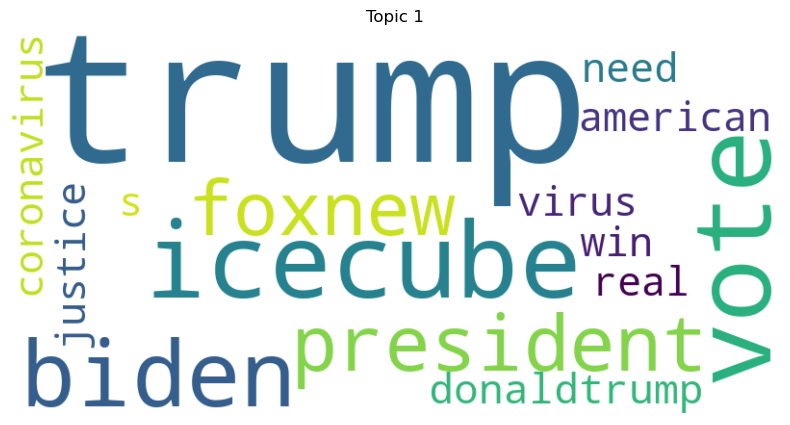

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



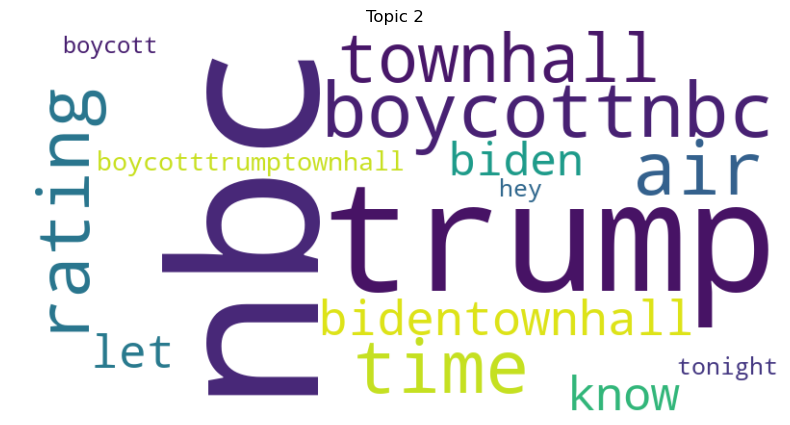

c:\Users\sheri\anaconda3\envs\tensor\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



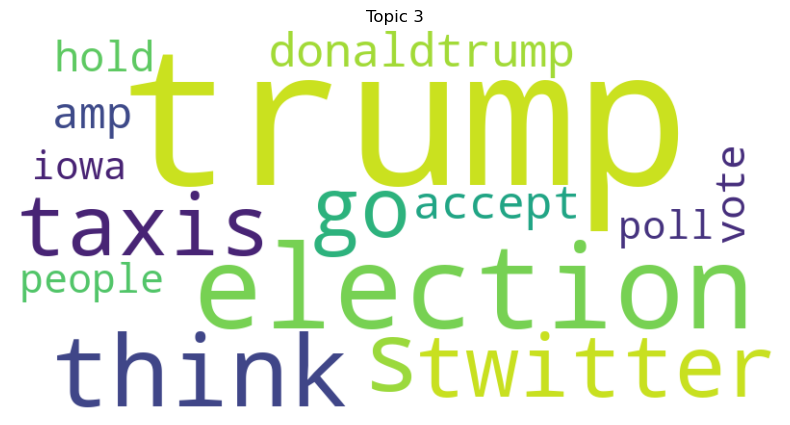

In [94]:
for topic_id in range(1,4):  # Replace num_topics with the actual number of topics
    words = dict(base_model.show_topic(topic_id, topn=15))  # Replace 15 with the number of words you want in the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id}")
    plt.show()

Coherence Score

In [95]:
base_perplexity = base_model.log_perplexity(corpus_l)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model_ldamul = CoherenceModel(model=base_model, texts=eng_df_filtered['lemma_tokens'], 
                                   dictionary=id2word_l, coherence='c_v')
coherence_lda_model_base = coherence_model_ldamul.get_coherence()
print('\nCoherence Score of LDA model is: ', coherence_lda_model_base)

     


Perplexity:  -8.372732190821422

Coherence Score of LDA model is:  0.38860677689123035


Hyperparameter Tuning

In [96]:
import optuna
import gensim
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary


# Define the objective function for Optuna
def objective(trial):
    num_topics = trial.suggest_int("num_topics", 90, 94)  # Suggest an integer value in the range [5, 20] for num_topics
    #alpha = trial.suggest_float("alpha", 0.01, 1.0)  # Suggest a float value in the range [0.01, 1.0] for alpha
    #eta = trial.suggest_float("eta", 0.01, 1.0)  # Suggest a float value in the range [0.01, 1.0] for eta
    workers = trial.suggest_int("workers", 11, 15)
    passes = trial.suggest_int("passes", 4,7)
    # Create and train the LdaMulticore model with the suggested hyperparameters
    model = LdaMulticore(
        corpus=corpus_l,
        id2word=id2word_l,
        num_topics=num_topics,
        #alpha=alpha,
        #eta=eta,
        workers=workers, 
        passes = passes # Set the number of CPU workers (adjust as needed)
    )

    # Compute the coherence score to evaluate the topic model
    coherence_model = CoherenceModel(model=model, texts=eng_df_filtered['lemma_tokens'], 
                                   dictionary=id2word_l, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score  # We aim to maximize the coherence score

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction="maximize")  # We want to maximize the coherence score
study.optimize(objective, n_trials=10)  # Perform 100 trials, you can increase this based on available resources

# Get the best hyperparameters and the corresponding model
best_hyperparameters = study.best_params
best_lda_model = LdaMulticore(
    corpus=corpus_l,
    id2word=id2word_l,
    num_topics=best_hyperparameters["num_topics"],
    #num_topics=94,
    #alpha=best_hyperparameters["alpha"],
    #eta=best_hyperparameters["eta"],
    workers=best_hyperparameters["workers"], 
    passes= best_hyperparameters["passes"]# Set the number of CPU workers (adjust as needed)
)

# Print the best hyperparameters
print(f"Best Hyperparameters:{best_hyperparameters}")
print(best_hyperparameters)


[I 2023-09-07 20:03:31,389] A new study created in memory with name: no-name-6710d329-b2b2-4a38-9bd3-0d7f1cf98f96


[I 2023-09-07 20:03:58,666] Trial 0 finished with value: 0.36754979028443996 and parameters: {'num_topics': 91, 'workers': 13, 'passes': 7}. Best is trial 0 with value: 0.36754979028443996.
[I 2023-09-07 20:04:22,362] Trial 1 finished with value: 0.38160334716813993 and parameters: {'num_topics': 92, 'workers': 12, 'passes': 6}. Best is trial 1 with value: 0.38160334716813993.
[I 2023-09-07 20:04:44,956] Trial 2 finished with value: 0.36350239203364343 and parameters: {'num_topics': 94, 'workers': 13, 'passes': 4}. Best is trial 1 with value: 0.38160334716813993.
[I 2023-09-07 20:05:08,313] Trial 3 finished with value: 0.38634117646179644 and parameters: {'num_topics': 94, 'workers': 13, 'passes': 4}. Best is trial 3 with value: 0.38634117646179644.
[I 2023-09-07 20:05:32,103] Trial 4 finished with value: 0.3829856046084945 and parameters: {'num_topics': 92, 'workers': 15, 'passes': 4}. Best is trial 3 with value: 0.38634117646179644.
[I 2023-09-07 20:05:56,122] Trial 5 finished with v

Best Hyperparameters:{'num_topics': 92, 'workers': 11, 'passes': 6}
{'num_topics': 92, 'workers': 11, 'passes': 6}


In [97]:
base_perplexity_best = best_lda_model.log_perplexity(corpus_l)
print('\nPerplexity: ', base_perplexity_best) 

# Compute Coherence Score
coherence_model_ldamul_best = CoherenceModel(model=best_lda_model, texts=eng_df_filtered['lemma_tokens'], 
                                   dictionary=id2word_l, coherence='c_v')
coherence_lda_model_base_best = coherence_model_ldamul_best.get_coherence()
print('\nCoherence Score of LDA model is: ', coherence_lda_model_base_best)


Perplexity:  -8.252368627550892

Coherence Score of LDA model is:  0.36723487836972896


Calculating accuracy, precision, recall, f1

In [215]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Sample DataFrame with 'label' column containing categorical labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column to convert labels into integers
eng_df_filter['label_encoded'] = label_encoder.fit_transform(eng_df_filter['label'])

# Print the modified DataFrame

eng_df_filter

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,entity,hashtags,filter_char,mul_spa,label_encoded,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,"[trump, student, hear, years, years, heard, ch...",trump student hear years years heard china 201...,"[trump, student, hear, year, year, hear, china...",trump student hear year year hear china 2019 1...,"[trump, student, hear, year, year, hear, china..."
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,"[2, hours, tweet, trump, maybe, busy, tremendo...",2 hours tweet trump maybe busy tremendously busy,"[2, hour, tweet, trump, maybe, busy, tremendou...",2 hour tweet trump maybe busy tremendously busy,"[hour, tweet, trump, maybe, busy, tremendously..."
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]"
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,"[15, minutes, long, time, ago, omarosa, repres...",15 minutes long time ago omarosa represented b...,"[15, minute, long, time, ago, omarosa, represe...",15 minute long time ago omarosa represent blac...,"[minute, long, time, ago, omarosa, represent, ..."
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,7,"[called, stupid, literally, donaldtrump]",called stupid literally donaldtrump,"[call, stupid, literally, donaldtrump]",call stupid literally donaldtrump,"[call, stupid, literally, donaldtrump]"
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,thewee

In [216]:
train_data, test_data = train_test_split(eng_df_filter, test_size=0.3)

In [217]:


# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_lg')
     

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(eng_df_filter['mul_spa'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
eng_df_filter['tokens'] = tokens
     

In [218]:


# Make tokens a string again
eng_df_filter['tokens_back_to_text'] = [' '.join(map(str, l)) for l in eng_df_filter['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

eng_df_filter['lemmas'] = eng_df_filter['tokens_back_to_text'].apply(get_lemmas)
     

# Make lemmas a string again
eng_df_filter['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in eng_df_filter['lemmas']]
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\\w*\\d\\w*', '', text) # Remove words containing numbers
    #tokens = re.sub('@*!*$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
eng_df_filter['lemma_tokens'] = eng_df_filter['lemmas_back_to_text'].apply(tokenize)
eng_df_filter

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,entity,hashtags,filter_char,mul_spa,label_encoded,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,20,"[trump, student, hear, years, years, heard, ch...",trump student hear years years heard china 201...,"[trump, student, hear, year, year, hear, china...",trump student hear year year hear china 2019 1...,"[trump, student, hear, year, year, hear, china..."
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,20,"[2, hours, tweet, trump, maybe, busy, tremendo...",2 hours tweet trump maybe busy tremendously busy,"[2, hour, tweet, trump, maybe, busy, tremendou...",2 hour tweet trump maybe busy tremendously busy,"[hour, tweet, trump, maybe, busy, tremendously..."
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,14,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]",tie tie trump s rally iowa,"[tie, tie, trump, s, rally, iowa]"
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,12,"[15, minutes, long, time, ago, omarosa, repres...",15 minutes long time ago omarosa represented b...,"[15, minute, long, time, ago, omarosa, represe...",15 minute long time ago omarosa represent blac...,"[minute, long, time, ago, omarosa, represent, ..."
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,7,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump, 2020]",glad u house dicktrump 2020,"[glad, u, house, dicktrump]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15-10-2020 00:19,1.320000e+18,"He just called @CoryBooker stupid, literally. ...",donaldtrump,0,0,Twitter for iPhone,1.791588e+07,hiphopdigital,hiphopdigital,...,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,he just called stupid literally donaldtrump,7,"[called, stupid, literally, donaldtrump]",called stupid literally donaldtrump,"[call, stupid, literally, donaldtrump]",call stupid literally donaldtrump,"[call, stupid, literally, donaldtrump]"
296,15-10-2020 00:19,1.320000e+18,"#TheWeek: ""NBC cut ties with #Trump in June 20...",trump,0,0,Twitter Web App,5.848852e+07,thelaughmakers@gmail.com,TheLaughMakers,...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,theweek nbc cut ties with trump in june 2015 ...,thewee

In [248]:
id2word_l_acc = Dictionary(eng_df_filter['lemma_tokens'])
print(len(id2word_l_acc))

1670


In [249]:
id2word_l_acc.filter_extremes(no_below=2, no_above=.99)
print(len(id2word_l_acc))

514


In [250]:
corpus_l_acc = [id2word_l_acc.doc2bow(d) for d in eng_df_filter['lemma_tokens']]

In [277]:
acc_base_model_lda = LdaMulticore(corpus=corpus_l_acc, num_topics=6, id2word=id2word_l_acc, workers=12, passes=5)

In [278]:
topics_lda_acc = acc_base_model_lda.print_topics(num_words=10)
for topic_acc_lda in topics_lda_acc:
    print(topic_acc_lda)
len(topics_lda_acc)

(0, '0.145*"trump" + 0.025*"not" + 0.013*"know" + 0.011*"s" + 0.010*"biden" + 0.010*"joebiden" + 0.009*"ask" + 0.009*"new" + 0.008*"election" + 0.008*"amp"')
(1, '0.088*"trump" + 0.025*"not" + 0.024*"donaldtrump" + 0.024*"people" + 0.023*"vote" + 0.019*"biden" + 0.017*"maga" + 0.012*"town" + 0.012*"hall" + 0.011*"amp"')
(2, '0.066*"trump" + 0.031*"not" + 0.024*"year" + 0.020*"s" + 0.018*"people" + 0.017*"need" + 0.017*"fear" + 0.015*"amp" + 0.015*"world" + 0.014*"death"')
(3, '0.027*"donaldtrump" + 0.026*"kag" + 0.026*"maga" + 0.025*"trump" + 0.021*"amp" + 0.014*"administration" + 0.011*"censorship" + 0.011*"americafirst" + 0.011*"million" + 0.011*"stupid"')
(4, '0.101*"trump" + 0.020*"not" + 0.017*"let" + 0.017*"amp" + 0.017*"donaldtrump" + 0.014*"lie" + 0.013*"good" + 0.012*"help" + 0.010*"people" + 0.010*"supporter"')
(5, '0.086*"trump" + 0.028*"biden" + 0.027*"donaldtrump" + 0.020*"amp" + 0.017*"twitter" + 0.013*"president" + 0.013*"people" + 0.013*"go" + 0.011*"joebiden" + 0.011*"

6

In [279]:
topic_word_tuples_acc=acc_base_model_lda.show_topics(num_topics=6, num_words=10, log=False, formatted=True)
topic_word_tuples_acc

[(0,
  '0.145*"trump" + 0.025*"not" + 0.013*"know" + 0.011*"s" + 0.010*"biden" + 0.010*"joebiden" + 0.009*"ask" + 0.009*"new" + 0.008*"election" + 0.008*"amp"'),
 (1,
  '0.088*"trump" + 0.025*"not" + 0.024*"donaldtrump" + 0.024*"people" + 0.023*"vote" + 0.019*"biden" + 0.017*"maga" + 0.012*"town" + 0.012*"hall" + 0.011*"amp"'),
 (2,
  '0.066*"trump" + 0.031*"not" + 0.024*"year" + 0.020*"s" + 0.018*"people" + 0.017*"need" + 0.017*"fear" + 0.015*"amp" + 0.015*"world" + 0.014*"death"'),
 (3,
  '0.027*"donaldtrump" + 0.026*"kag" + 0.026*"maga" + 0.025*"trump" + 0.021*"amp" + 0.014*"administration" + 0.011*"censorship" + 0.011*"americafirst" + 0.011*"million" + 0.011*"stupid"'),
 (4,
  '0.101*"trump" + 0.020*"not" + 0.017*"let" + 0.017*"amp" + 0.017*"donaldtrump" + 0.014*"lie" + 0.013*"good" + 0.012*"help" + 0.010*"people" + 0.010*"supporter"'),
 (5,
  '0.086*"trump" + 0.028*"biden" + 0.027*"donaldtrump" + 0.020*"amp" + 0.017*"twitter" + 0.013*"president" + 0.013*"people" + 0.013*"go" + 0.0

In [280]:
wl_acc_lda= acc_base_model_lda.top_topics(corpus=corpus_l_acc, texts=eng_df_filter['mul_spa'], dictionary=id2word_l_acc, window_size=None, coherence='u_mass', topn=20, processes=-1)
wl_acc_lda

[([(0.06560793, 'trump'),
   (0.031024402, 'not'),
   (0.023916842, 'year'),
   (0.019721307, 's'),
   (0.0175025, 'people'),
   (0.017000219, 'need'),
   (0.016917901, 'fear'),
   (0.01482082, 'amp'),
   (0.014624075, 'world'),
   (0.013529163, 'death'),
   (0.012810071, 'black'),
   (0.012000667, 'gop'),
   (0.011834218, 'trumpisalaughingstock'),
   (0.010282362, 'believe'),
   (0.010272839, 'u'),
   (0.009818905, 'look'),
   (0.009535926, 'fool'),
   (0.009490741, 'trumpcrimefamily'),
   (0.00860017, 'dumptrump'),
   (0.008598318, 'covidiot')],
  -10.698690698526153),
 ([(0.100614406, 'trump'),
   (0.02005674, 'not'),
   (0.017463164, 'let'),
   (0.017085465, 'amp'),
   (0.016533498, 'donaldtrump'),
   (0.01412403, 'lie'),
   (0.013222097, 'good'),
   (0.012222161, 'help'),
   (0.010287715, 'people'),
   (0.010240042, 'supporter'),
   (0.010138698, 'day'),
   (0.009281402, 'say'),
   (0.008445316, 'usa'),
   (0.008263804, 'tweet'),
   (0.008260607, 'line'),
   (0.0082570845, 'work')

In [281]:
# Initialize an empty dictionary to store the result
topic_dict_acc_lda = {}

# Iterate through the topic-word tuples and convert them into a dictionary
for topic_id_acc_l, words_acc_l in topic_word_tuples_acc:
    # Split the words string into a list of words using '+' as the delimiter
    words_list_acc_l = words_acc_l.split(' + ')
    
    # Extract only the words (discard the probabilities)
    words_list_acc_l = [word.split('*')[1].strip('\"') for word in words_list_acc_l]
    
    # Add the topic to the dictionary with the list of words as the value
    topic_dict_acc_lda[topic_id_acc_l] = words_list_acc_l

# Now, topic_dict contains the topics with their representative words
print(topic_dict_acc_lda)

{0: ['trump', 'not', 'know', 's', 'biden', 'joebiden', 'ask', 'new', 'election', 'amp'], 1: ['trump', 'not', 'donaldtrump', 'people', 'vote', 'biden', 'maga', 'town', 'hall', 'amp'], 2: ['trump', 'not', 'year', 's', 'people', 'need', 'fear', 'amp', 'world', 'death'], 3: ['donaldtrump', 'kag', 'maga', 'trump', 'amp', 'administration', 'censorship', 'americafirst', 'million', 'stupid'], 4: ['trump', 'not', 'let', 'amp', 'donaldtrump', 'lie', 'good', 'help', 'people', 'supporter'], 5: ['trump', 'biden', 'donaldtrump', 'amp', 'twitter', 'president', 'people', 'go', 'joebiden', 'trumpliesamericansdie']}


In [282]:
word_list_df_acc = pd.DataFrame(list(topic_dict_acc_lda.items()), columns=['Topic ID', 'Words'])

# Rename the columns
#word_list_df.columns = ['Topic ID', 'List of Words']

# Display the DataFrame
word_list_df_acc

,Topic ID,Words
0,0,"[trump, not, know, s, biden, joebiden, ask, ne..."
1,1,"[trump, not, donaldtrump, people, vote, biden,..."
2,2,"[trump, not, year, s, people, need, fear, amp,..."
3,3,"[donaldtrump, kag, maga, trump, amp, administr..."
4,4,"[trump, not, let, amp, donaldtrump, lie, good,..."
5,5,"[trump, biden, donaldtrump, amp, twitter, pres..."


In [283]:

# Initialize a list to store topic assignments for each document
document_topics_acc_l = []

# Iterate through each document in the corpus
for document_acc_l in corpus_l_acc:
    # Get the topic distribution for the document
    topic_distribution_acc_l = acc_base_model_lda[document_acc_l]
    
    # Sort the topic distribution by probability and get the most likely topic
    most_likely_topic_acc_l = max(topic_distribution_acc_l, key=lambda item: item[1])
    
    # Append the topic ID to the list
    document_topics_acc_l.append(most_likely_topic_acc_l[0])

# Now, document_topics contains the assigned topic IDs for each document
print(document_topics_acc_l)
doc_top_acc_l=document_topics_acc_l[:100]
len(doc_top_acc_l)

[0, 0, 2, 1, 2, 1, 2, 0, 0, 0, 3, 5, 0, 0, 5, 5, 1, 4, 0, 4, 5, 5, 5, 5, 0, 2, 1, 4, 4, 1, 0, 5, 5, 2, 4, 4, 1, 1, 0, 5, 0, 1, 1, 5, 0, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 4, 1, 4, 1, 4, 4, 5, 3, 4, 1, 4, 1, 1, 2, 0, 4, 2, 5, 5, 1, 2, 1, 3, 5, 4, 5, 4, 1, 0, 1, 5, 5, 2, 5, 5, 0, 0, 4, 0, 5, 4, 4, 4, 0, 5, 0, 5, 0, 1, 3, 5, 4, 5, 4, 2, 5, 4, 3, 4, 4, 0, 4, 2, 5, 0, 0, 5, 0, 0, 0, 4, 0, 4, 0, 0, 3, 5, 1, 0, 1, 4, 5, 0, 0, 0, 2, 2, 2, 0, 0, 2, 4, 4, 1, 5, 5, 0, 5, 5, 0, 5, 0, 4, 2, 1, 0, 4, 4, 5, 5, 0, 1, 2, 0, 2, 1, 2, 1, 2, 4, 0, 4, 1, 3, 0, 1, 4, 4, 5, 2, 2, 2, 0, 0, 1, 2, 5, 5, 1, 0, 1, 5, 1, 2, 0, 0, 1, 1, 0, 1, 4, 0, 2, 0, 0, 4, 2, 2, 5, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 1, 5, 0, 5, 0, 0, 2, 1, 2, 5, 4, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 5, 2, 1, 1, 5, 0, 4, 4, 5, 1, 3, 0, 0, 5, 0, 2, 0, 2, 0, 4, 4, 1, 1, 0, 0, 1, 5, 5, 5, 2, 4, 1, 0, 4, 1, 4, 2, 5, 0, 0, 2, 0, 4, 0, 5, 4, 3, 2, 2, 2, 0]


100

In [284]:
eng_df_filter1 = tweet_df.iloc[0:100]
  # Randomly sample 300,000 records
eng_df_filter1

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,continent,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,North America,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,North America,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,North America,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15-10-2020 00:05,1.320000e+18,@icecube You don’t trust ‘none of them’ (Presi...,trump,0,0,Twitter for iPhone,3.047179e+09,The Doctah,DrMovieManiac,...,NaN,NaN,NaN,00:40.7,en,@icecube You don’t trust ‘none of them’ (Presi...,you dont trust none of them presidential cand...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...
96,15-10-2020 00:05,1.320000e+18,@maddow #AmyConeyBarrett can remember case aft...,trump,0,0,Twitter for Android,1.200000e+18,Ex- Republican,DemocratNel,...,NaN,NaN,NaN,00:41.1,en,@maddow #AmyConeyBarrett can remember case aft...,amyconeybarrett can remember case after case ...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...
97,15-10-2020 00:05,1.320000e+18,@donwinslow #trump is the #monster #TrumpIsNot...,trump,0,0,Twitter for iPhone,1.180000e+18,Dee Smiff,smiff_dee,...,NaN,NaN,NaN,00:41.4,en,@donwinslow #trump is the #monster #TrumpIsNot...,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica
98,15-10-2020 00:05,1.320000e+18,@hughriminton All off #Trump merchandise is ma...,trump,0,0,Twitter for Android,9.510000e+17,Jeffrey Kennedy,kennoJT,...,NaN,NaN,NaN,00:42.2,en,@hughriminton All off #Trump merchandise is ma...,all off trump merchandise is made in china i ...,all off trump merchandise is made in china i d...,all off

In [285]:
eng_df_filter1['predicted_value_lda'] = doc_top_acc_l

# Display the updated DataFrame
eng_df_filter1

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,state,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa,predicted_value_lda
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,Oregon,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,0
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,0
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,District of Columbia,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,2
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,California,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,1
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15-10-2020 00:05,1.320000e+18,@icecube You don’t trust ‘none of them’ (Presi...,trump,0,0,Twitter for iPhone,3.047179e+09,The Doctah,DrMovieManiac,...,NaN,NaN,00:40.7,en,@icecube You don’t trust ‘none of them’ (Presi...,you dont trust none of them presidential cand...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,4
96,15-10-2020 00:05,1.320000e+18,@maddow #AmyConeyBarrett can remember case aft...,trump,0,0,Twitter for Android,1.200000e+18,Ex- Republican,DemocratNel,...,NaN,NaN,00:41.1,en,@maddow #AmyConeyBarrett can remember case aft...,amyconeybarrett can remember case after case ...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,4
97,15-10-2020 00:05,1.320000e+18,@donwinslow #trump is the #monster #TrumpIsNot...,trump,0,0,Twitter for iPhone,1.180000e+18,Dee Smiff,smiff_dee,...,NaN,NaN,00:41.4,en,@donwinslow #trump is the #monster #TrumpIsNot...,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,4
98,15-10-2020 00:05,1.320000e+18,@hughriminton All off #Trump merchandise is ma...,trump,0,0,Twitter for Android,9.510000e+17,Jeffrey Kennedy,kennoJT,...,NaN,NaN,00:42.2,en,@hughriminton All off #Trump merchandise is ma...,all off trump merchandise is made in china i ...,all off trump merchandise is made in china i d...,all off trump merchandise is made in china i d.

In [286]:
def map_topic_lda(label):
    filtered_row_acc = word_list_df_acc[word_list_df_acc['Topic ID'] == label]

# Extract the 'Words' value from the filtered row (assuming it's a list)
    if not filtered_row_acc.empty:
        words_list_acc = filtered_row_acc.iloc[0]['Words']
    return words_list_acc

In [287]:
eng_df_filter1["predicted_topic_lda"]=eng_df_filter1["predicted_value_lda"].map(map_topic_lda)
eng_df_filter1

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,state_code,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa,predicted_value_lda,predicted_topic_lda
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,OR,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,0,"[trump, not, know, s, biden, joebiden, ask, ne..."
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,NaN,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,0,"[trump, not, know, s, biden, joebiden, ask, ne..."
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,DC,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,2,"[trump, not, year, s, people, need, fear, amp,..."
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,CA,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,1,"[trump, not, donaldtrump, people, vote, biden,..."
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,NaN,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,2,"[trump, not, year, s, people, need, fear, amp,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15-10-2020 00:05,1.320000e+18,@icecube You don’t trust ‘none of them’ (Presi...,trump,0,0,Twitter for iPhone,3.047179e+09,The Doctah,DrMovieManiac,...,NaN,00:40.7,en,@icecube You don’t trust ‘none of them’ (Presi...,you dont trust none of them presidential cand...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,4,"[trump, not, let, amp, donaldtrump, lie, good,..."
96,15-10-2020 00:05,1.320000e+18,@maddow #AmyConeyBarrett can remember case aft...,trump,0,0,Twitter for Android,1.200000e+18,Ex- Republican,DemocratNel,...,NaN,00:41.1,en,@maddow #AmyConeyBarrett can remember case aft...,amyconeybarrett can remember case after case ...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,4,"[trump, not, let, amp, donaldtrump, lie, good,..."
97,15-10-2020 00:05,1.320000e+18,@donwinslow #trump is the #monster #TrumpIsNot...,trump,0,0,Twitter for iPhone,1.180000e+18,Dee Smiff,smiff_dee,...,NaN,00:41.4,en,@donwinslow #trump is the #monster #TrumpIsNot...,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,4,"[trump, not, let, amp, donaldtrump, lie, good,...

In [288]:
#Assigning the predicted label to each tweet
def check_value_in_list(value, target_list):
    if value in target_list:
        word = value
    else:
        word = target_list[0]
    return word


In [289]:
eng_df_filter1['predict_lda'] = eng_df_filter1.apply(lambda row: check_value_in_list(row['label'], row['predicted_topic_lda']), axis=1)
eng_df_filter1

,created_at,tweet_id,tweet,label,likes,retweet_count,source,user_id,user_name,user_screen_name,...,collected_at,language,emoji,entity,hashtags,filter_char,mul_spa,predicted_value_lda,predicted_topic_lda,predict_lda
0,15-10-2020 00:00,1.320000e+18,"#Trump: As a student I used to hear for years,...",trump,2,1,Twitter Web App,8.436472e+06,snarke,snarke,...,00:00.7,en,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,trump as a student i used to hear for years fo...,0,"[trump, not, know, s, biden, joebiden, ask, ne...",trump
1,15-10-2020 00:00,1.320000e+18,2 hours since last tweet from #Trump! Maybe he...,trump,0,0,Trumpytweeter,8.280000e+17,Trumpytweeter,trumpytweeter,...,00:01.1,en,2 hours since last tweet from #Trump! Maybe he...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,2 hours since last tweet from trump maybe he i...,0,"[trump, not, know, s, biden, joebiden, ask, ne...",trump
2,15-10-2020 00:00,1.320000e+18,You get a tie! And you get a tie! #Trump ‘s ra...,iowa,4,3,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,...,00:01.5,en,You get a tie! And you get a tie! #Trump ‘s ra...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,you get a tie and you get a tie trump s rally ...,2,"[trump, not, year, s, people, need, fear, amp,...",trump
3,15-10-2020 00:00,1.320000e+18,@CLady62 Her 15 minutes were over long time ag...,her,2,0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,...,00:01.9,en,@CLady62 Her 15 minutes were over long time ag...,her 15 minutes were over long time ago omaros...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,her 15 minutes were over long time ago omarosa...,1,"[trump, not, donaldtrump, people, vote, biden,...",trump
4,15-10-2020 00:00,1.320000e+18,@richardmarx Glad u got out of the house! DICK...,donaldtrump,0,0,Twitter for iPhone,7.670000e+17,Michael Wilson,wilsonfire9,...,00:02.2,en,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,glad u got out of the house dicktrump 2020,2,"[trump, not, year, s, people, need, fear, amp,...",trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15-10-2020 00:05,1.320000e+18,@icecube You don’t trust ‘none of them’ (Presi...,trump,0,0,Twitter for iPhone,3.047179e+09,The Doctah,DrMovieManiac,...,00:40.7,en,@icecube You don’t trust ‘none of them’ (Presi...,you dont trust none of them presidential cand...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,you dont trust none of them presidential candi...,4,"[trump, not, let, amp, donaldtrump, lie, good,...",trump
96,15-10-2020 00:05,1.320000e+18,@maddow #AmyConeyBarrett can remember case aft...,trump,0,0,Twitter for Android,1.200000e+18,Ex- Republican,DemocratNel,...,00:41.1,en,@maddow #AmyConeyBarrett can remember case aft...,amyconeybarrett can remember case after case ...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,amyconeybarrett can remember case after case b...,4,"[trump, not, let, amp, donaldtrump, lie, good,...",trump
97,15-10-2020 00:05,1.320000e+18,@donwinslow #trump is the #monster #TrumpIsNot...,trump,0,0,Twitter for iPhone,1.180000e+18,Dee Smiff,smiff_dee,...,00:41.4,en,@donwinslow #trump is the #monster #TrumpIsNot...,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,trump is the monster trumpisnotamerica,4,"[trump, not, let, amp, donaldtrump,

In [290]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
lda_label=eng_df_filter1["label"].tolist()
predict_lda=eng_df_filter1["predict_lda"].tolist()

# Calculate accuracy
accuracy_lda = accuracy_score(lda_label, predict_lda)

# Calculate precision
precision_lda = precision_score(lda_label, predict_lda, average='weighted')

# Calculate recall (which is the same as sensitivity)
recall_lda = recall_score(lda_label, predict_lda, average='weighted')

# Calculate F1-score
f1_lda = f1_score(lda_label, predict_lda, average='weighted')

# Print the calculated metrics
print(f"Accuracy of LDA: {accuracy_lda:}")
print(f"Precision of LDA: {precision_lda:}")
print(f"Recall of LDA: {recall_lda:}")
print(f"F1-score of LDA: {f1_lda:}")


Accuracy of LDA: 0.64
Precision of LDA: 0.4907051282051282
Recall of LDA: 0.64
F1-score of LDA: 0.5300437158469945


In [291]:
from sklearn.metrics import classification_report
print(classification_report(lda_label, predict_lda))

              precision    recall  f1-score   support

       biden       1.00      1.00      1.00         4
       black       0.00      0.00      0.00         1
  corruption       0.00      0.00      0.00         5
     covid19       0.00      0.00      0.00         3
 donaldtrump       0.75      0.86      0.80         7
election2020       0.00      0.00      0.00         8
        fear       1.00      1.00      1.00         5
         her       0.00      0.00      0.00         2
herdimmunity       0.00      0.00      0.00         5
        iowa       0.00      0.00      0.00         1
       trump       0.56      1.00      0.72        44
   trump2020       0.00      0.00      0.00         5
     twitter       1.00      0.50      0.67        10

    accuracy                           0.64       100
   macro avg       0.33      0.34      0.32       100
weighted avg       0.49      0.64      0.53       100



<Figure size 800x600 with 0 Axes>

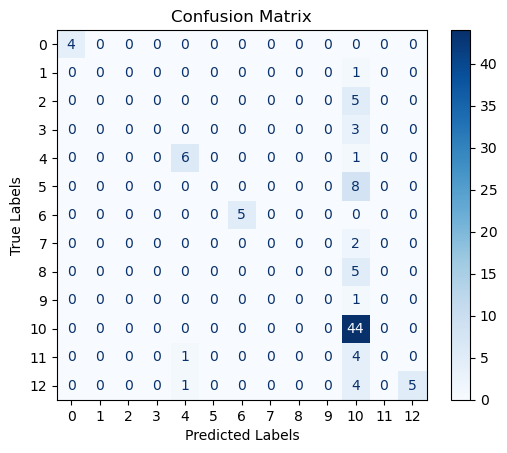

In [292]:
cm_lda_acc = confusion_matrix(lda_label, predict_lda)

# Create a ConfusionMatrixDisplay object
cm_display_lda_acc = ConfusionMatrixDisplay(confusion_matrix=cm_lda_acc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display_lda_acc.plot(cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


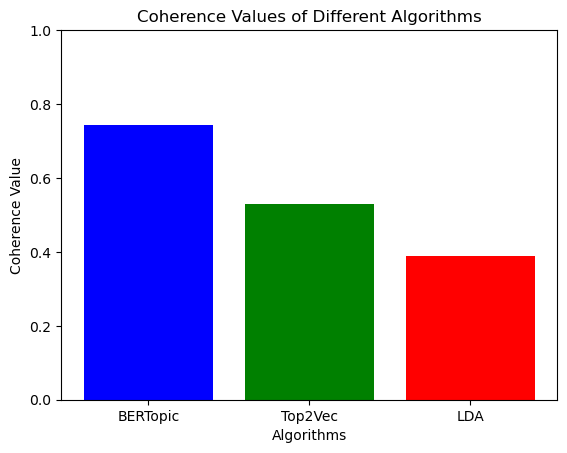

In [293]:
import matplotlib.pyplot as plt

# Example coherence values for each algorithm

algorithms = ['BERTopic', 'Top2Vec', 'LDA']
coherence_values = [coherence_bert, coherence_top, coherence_lda_model_base]

plt.bar(algorithms, coherence_values, color=['blue', 'green', 'red'])
plt.xlabel('Algorithms')
plt.ylabel('Coherence Value')
plt.title('Coherence Values of Different Algorithms')
plt.ylim(0, 1.0)  # Adjust the y-axis limits as needed
plt.show()


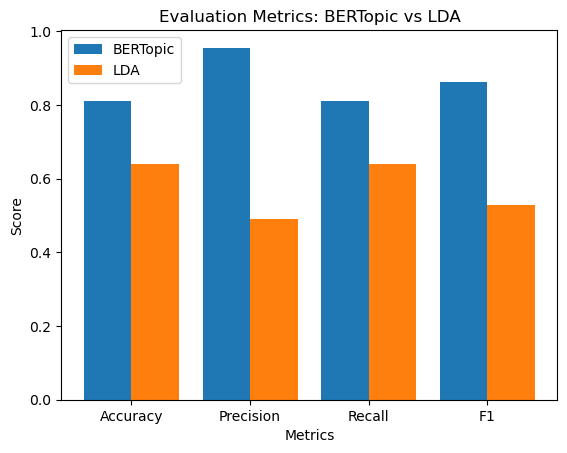

In [294]:
import matplotlib.pyplot as plt

# Example metric values for BERTopic and LDA

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
bertopic_scores = [accuracy_bert, precision_bert, recall_bert, f1_bert]
lda_scores = [accuracy_lda, precision_lda, recall_lda, f1_lda]

x = list(range(len(metrics)))

plt.bar(x, bertopic_scores, width=0.4, label='BERTopic', align='center')
plt.bar([i + 0.4 for i in x], lda_scores, width=0.4, label='LDA', align='center')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics: BERTopic vs LDA')
plt.xticks([i + 0.2 for i in x], metrics)
plt.legend()
plt.show()


In [295]:
import pandas as pd

# Example list of topic modeling results
topic_modeling_results = [
    {'model': 'BERTopic', 'coherence_score':coherence_bert},
    {'model': 'Top2Vec', 'coherence_score': coherence_top},
    {'model': 'LDA', 'coherence_score': coherence_lda_model_base},
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_cohere = pd.DataFrame(topic_modeling_results)

df_cohere


,model,coherence_score
0,BERTopic,0.743340
1,Top2Vec,0.529590
2,LDA,0.388607


In [296]:
topic_modeling_eval = [
    {'model': 'BERTopic', 'accuracy':accuracy_bert,'recall':recall_bert,'precision':precision_bert,'F1':f1_bert},
    {'model': 'LDA', 'accuracy':accuracy_lda,'recall':recall_lda,'precision':precision_lda,'F1':f1_lda},
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_eval = pd.DataFrame(topic_modeling_eval)

df_eval

,model,accuracy,recall,precision,F1
0,BERTopic,0.81,0.81,0.955714,0.863985
1,LDA,0.64,0.64,0.490705,0.530044


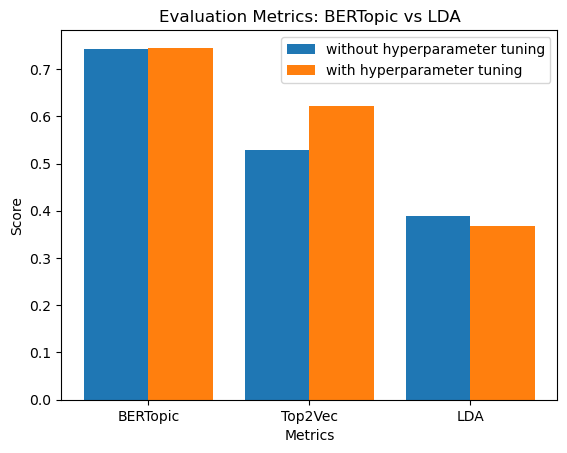

In [297]:
import matplotlib.pyplot as plt

# Example metric values for BERTopic and LDA

metrics = ['BERTopic', 'Top2Vec', 'LDA']
coherence_score_1 = [coherence_bert, coherence_top, coherence_lda_model_base]
hyper_cohere = [coherence_best, coherence_sc_besttop, coherence_lda_model_base_best]

x = list(range(len(metrics)))

plt.bar(x, coherence_score_1, width=0.4, label='without hyperparameter tuning', align='center')
plt.bar([i + 0.4 for i in x], hyper_cohere, width=0.4, label='with hyperparameter tuning', align='center')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Evaluation Metrics: BERTopic vs LDA')
plt.xticks([i + 0.2 for i in x], metrics)
plt.legend()
plt.show()


In [298]:
import pandas as pd

# Example list of topic modeling results
topic_modeling__hyper_results = [
    {'model': 'BERTopic', 'coherence_score':coherence_best},
    {'model': 'Top2Vec', 'coherence_score': coherence_sc_besttop},
    {'model': 'LDA', 'coherence_score': coherence_lda_model_base_best},
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_cohere_hyp = pd.DataFrame(topic_modeling__hyper_results)

df_cohere_hyp

,model,coherence_score
0,BERTopic,0.745121
1,Top2Vec,0.622009
2,LDA,0.367235


In [299]:
import pandas as pd

# Example list of topic modeling results
topic_bert__hyper_results = [
    {'model': 'BERTopic without hyperparameter tuning', 'coherence_score':coherence_bert},
    {'model': 'BERTopic with hyperparameter tuning', 'coherence_score': coherence_best},
    
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_cohere_hyp_bert = pd.DataFrame(topic_bert__hyper_results)

df_cohere_hyp_bert

,model,coherence_score
0,BERTopic without hyperparameter tuning,0.743340
1,BERTopic with hyperparameter tuning,0.745121


In [300]:
import pandas as pd

# Example list of topic modeling results
topic_top2vec__hyper_results = [
    {'model': 'Top2Vec without hyperparameter tuning', 'coherence_score':coherence_top},
    {'model': 'Top2Vec with hyperparameter tuning', 'coherence_score': coherence_sc_besttop},
    
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_cohere_hyp_top2vec = pd.DataFrame(topic_top2vec__hyper_results)

df_cohere_hyp_top2vec

,model,coherence_score
0,Top2Vec without hyperparameter tuning,0.529590
1,Top2Vec with hyperparameter tuning,0.622009


In [301]:
import pandas as pd

# Example list of topic modeling results
topic_lda__hyper_results = [
    {'model': 'LDA without hyperparameter tuning', 'coherence_score':coherence_lda_model_base},
    {'model': 'LDA with hyperparameter tuning', 'coherence_score': coherence_lda_model_base_best},
    
    # ... more results ...
]

# Convert the list of results into a pandas DataFrame
df_cohere_hyp_lda = pd.DataFrame(topic_lda__hyper_results)

df_cohere_hyp_lda

,model,coherence_score
0,LDA without hyperparameter tuning,0.388607
1,LDA with hyperparameter tuning,0.367235


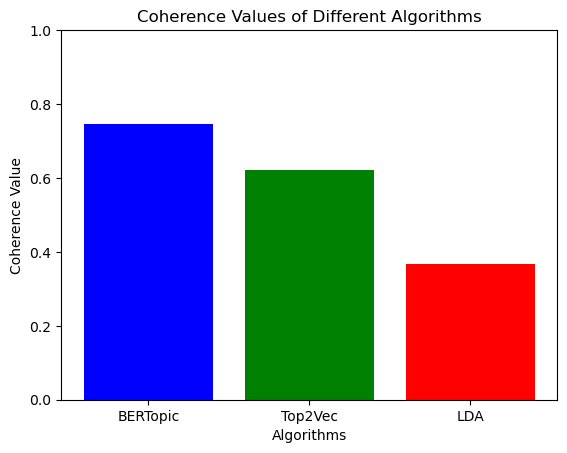

In [302]:
import matplotlib.pyplot as plt

# Example coherence values for each algorithm

algorithms = ['BERTopic', 'Top2Vec', 'LDA']
coherence_values_hy = [coherence_best, coherence_sc_besttop, coherence_lda_model_base_best]

plt.bar(algorithms, coherence_values_hy, color=['blue', 'green', 'red'])
plt.xlabel('Algorithms')
plt.ylabel('Coherence Value')
plt.title('Coherence Values of Different Algorithms')
plt.ylim(0, 1.0)  # Adjust the y-axis limits as needed
plt.show()
